# Research on the Real Estate Market for Apartment Sales

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Будем учиться определять рыночную стоимость объектов недвижимости. 

Основная задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.


In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('../datasets/real_estate_data.csv')
df_check = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)

In [292]:
#`idx_to_be_removed`. Содержит индексы строк исходного датафрейма, которые подлежат удалению в следствии каких-либо причин.
# На основе данного массива мы проведем выясним процент данных необходимым для удаления, в рамках исходной задачи
idx_to_be_removed = []

#Для учета будем использовать конструкцию:
#idx_to_be_removed.extend(data.index)

# Функцию для оценки величины потеряных данных:
def testdatalost(lost):
    if lost <= 473:
        return print("Несущественные потери\n")
    elif lost <= 1184:
        return print("Допустимые потери\n")
    elif lost <= 2369:
        return print("Критичные потери для корректного анализа\n")
    else:
        return print("Ошибка((\n")


In [293]:
data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')
data_orig = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')

## Обзор датасета

In [294]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [295]:
# Базовая проверка структуры датафрэйма
data.info()
print()
print(f'Размер датафрэйма: Строк {data.shape[0]}, Столбцов {data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [296]:
# Приведем в порядок заголовки признаков
data = data.rename(columns={'studio': 'is_studio'})
data = data.rename(columns={'open_plan': 'is_open_plan'})
data = data.rename(columns={'airports_nearest': 'distance_to_nearest_airport'})
data = data.rename(columns={'cityCenters_nearest': 'distance_to_downtown'})
data = data.rename(columns={'parks_around3000': 'num_of_parks_around_3000m'})
data = data.rename(columns={'parks_nearest': 'distance_to_nearest_park'})
data = data.rename(columns={'ponds_around3000': 'num_of_ponds_around_3000m','ponds_nearest': 'distance_to_nearest_pond'})
data.columns
data = data.rename(columns={'ponds_around3000': 'num_of_ponds_around_3000m','ponds_nearest': 'distance_to_nearest_pond'})
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'distance_to_nearest_airport', 'distance_to_downtown',
       'num_of_parks_around_3000m', 'distance_to_nearest_park',
       'num_of_ponds_around_3000m', 'distance_to_nearest_pond',
       'days_exposition'],
      dtype='object')

In [297]:
print(data['is_apartment'].unique().sum())
data.head(10)

nan


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,distance_to_nearest_airport,distance_to_downtown,num_of_parks_around_3000m,distance_to_nearest_park,num_of_ponds_around_3000m,distance_to_nearest_pond,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


**Промежуточный вывод**

Можно заметить что данные не однородны, наблюдается большое количество пропусков, которые будут влиять на степень правильной интерпретации, поэтому на этапе предоброботки данных, нужно будет уделить особое внимание тому как следует бороться с незаполнеными значениями так что бы достоверность аналитики как минимум не ухудшилась

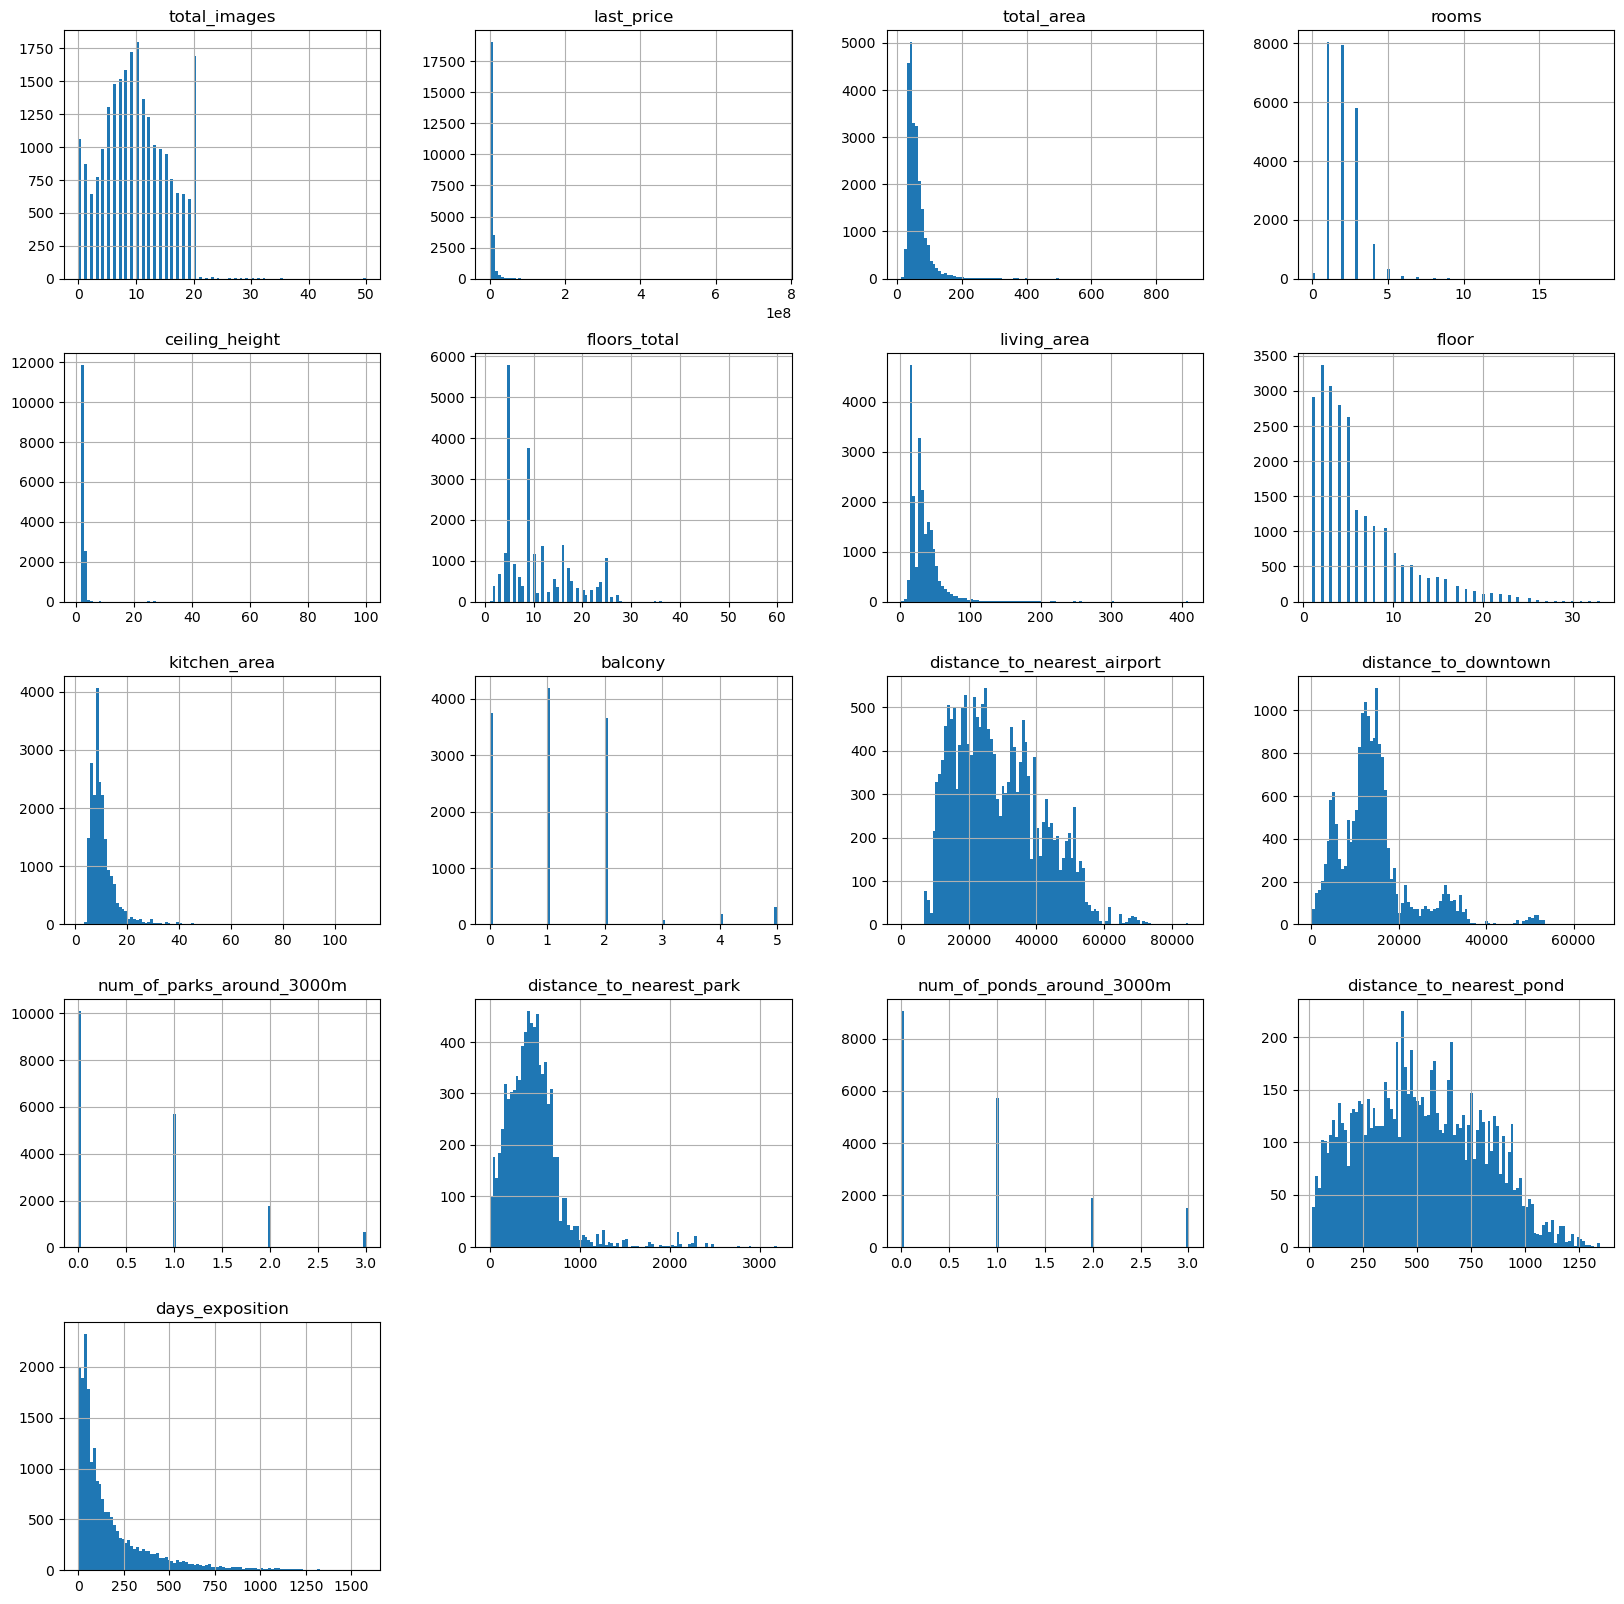

In [298]:
# Посмотрим на гистограммы для всех числовых столбцов
data.hist(figsize=(20,20), bins=100);

**Промежуточные выводы**

- `total_images` - в целом график выглядит правдоподобным кроме скачка у 20 фотографий, это выглядит подозрительным и требует более детального изучения.    
- `last_price` - здесь явно что-то не так, график сильно искажен, возможное имеются сильные выбросы. Надо изучать доп-но
- `total_area` - пока вопросов нет    
- `rooms` - колличество комнат 0 и больше 5 вызывают сомнения. Нужен более детальный анализ
- `ceiling_height` - здесь явно что-то не так, график сильно искажен, возможное имеются сильные выбросы. Надо изучать доп-но    
- `floors_total` - похоже есть выбросы плюс отсутсвует кореляция с графиком `floor` что само посебе странно
- `living_area` - похоже есть выбросы       
- `kitchecn_area` - похоже есть выбросы 
- `balcony` - есть вопросы к объявлениям с колличеством балконов больше 2     
- `distance_to_nearest_airport` - странные значения. Данные требуют более глубокого анализа 
- `distance_to_downtown` - странные значения. Данные требуют более глубокого анализа     
- `num_of_parks_around_3000m` - пока вопросов нет 
- `distance_to_nearest_park` - значения свше 3000 м требуют анализа чтобы понять природы выброса    
- `num_of_ponds_around_3000m` - пока вопросов нет 
- `distance_to_nearest_pond` - пока вопросов нет     
- `days_exposition` - пока вопросов нет 


In [299]:
#Расчитаем допустимые потери        
for i in [2,5,10]:
    print(i, '% это', int(len(data)*i/100),'строк датафрейма.\n')

2 % это 473 строк датафрейма.

5 % это 1184 строк датафрейма.

10 % это 2369 строк датафрейма.



**Промежуточный вывод**

После первичного анализа данных, мы видим что исходные данные не готовы для анализа, так как в них отсутсвует множество информации, неверные типы данных, и не описательные заголовки серий поэтому на этапе предобработки данных нам прийдется избавляться от части строк (выбросы, неполные и недостоверные данные и т.п.). 
В масштабе 23.7 тыс. записей критерии потерь данных можно установить следующим образом:
        
`2 < % потери < 10` от числа всех записей - несущественная потеря;

`потери > 10%` -  однозначно исказят результаты анализа.

## Предобработка данных

### Конвертируем серии в более подходящие типы данных

- first_day_exposition object дата публикации. Требует конвертации в DateTime    
- floors_total float64 всего этажей в доме. Требует конвертации в int
- is_apartment object апартаменты.Требует конвертации в bool    
- balcony float64 число балконов. Требует конвертации в int
- num_of_parks_around_3000m float64 число парков в радиусе 3 км. Требует конвертации в int     
- num_of_ponds_around_3000m float64 число водоёмов в радиусе 3 км. Требует конвертации в int 


In [300]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype(float).astype('Int64')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype(float).astype('Int64')
data['num_of_parks_around_3000m'] =  data['num_of_parks_around_3000m'].astype(float).astype('Int64')
data['num_of_ponds_around_3000m'] =  data['num_of_ponds_around_3000m'].astype(float).astype('Int64')
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,distance_to_nearest_airport,distance_to_downtown,num_of_parks_around_3000m,distance_to_nearest_park,num_of_ponds_around_3000m,distance_to_nearest_pond,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,<NA>,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,True,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,<NA>,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


### Обработаем пропущенные значения

In [301]:
n = 0
print( f'IDX', f' Column name', f'                 NaN count', f'              NaN %')
print('------------------------------------------------------------------------------')
for column in data.columns:
    
    if data[column].isna().sum() > 0:
        na_column = data[column].isna().sum()
        na_percent = (100 * na_column / len(data)).round(2)
        print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc(column), data.columns[n], f'{na_column}', f'{na_percent}'))
        
    n += 1

IDX  Column name                  NaN count               NaN %
------------------------------------------------------------------------------
5   ceiling_height                 9195                 38.8                
6   floors_total                   86                   0.36                
7   living_area                    1903                 8.03                
12  kitchen_area                   2278                 9.61                
13  balcony                        11519                48.61               
14  locality_name                  49                   0.21                
15  distance_to_nearest_airport    5542                 23.38               
16  distance_to_downtown           5519                 23.29               
17  num_of_parks_around_3000m      5518                 23.28               
18  distance_to_nearest_park       15620                65.91               
19  num_of_ponds_around_3000m      5518                 23.28               
20  distan

In [302]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

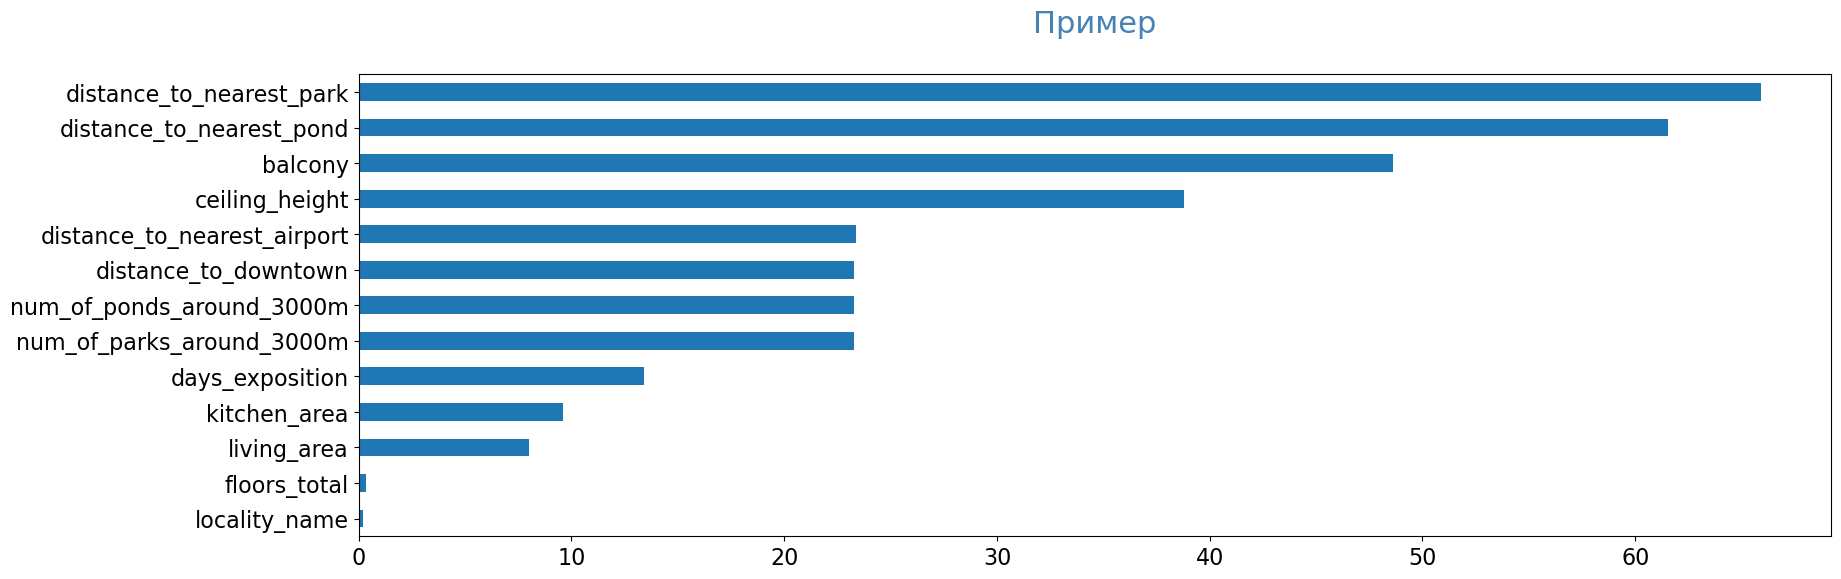

In [303]:
pass_value_barh(data)


##### `last_price` Цена объекта

In [304]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

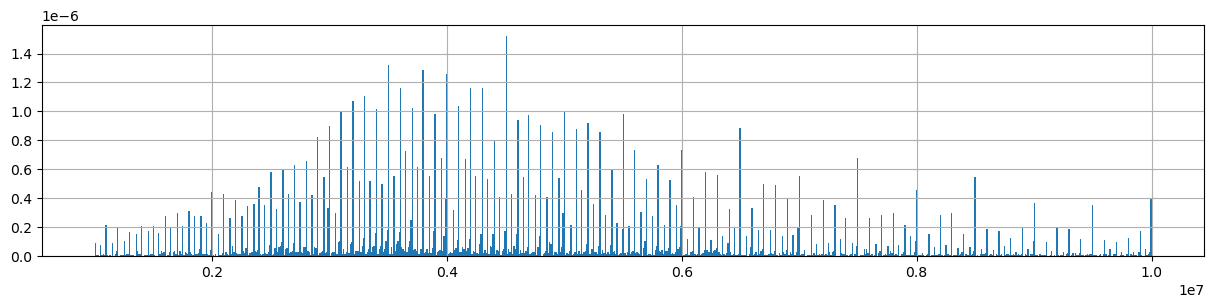

In [305]:
data.last_price.hist(bins = 800, figsize = (15,3), range = (1000000,10000000), density= 'false');


In [306]:
#Проверим, сколько объявлений очень дорогой недвижимости в нашем датасете:
#expensive = len(data['last_price'][data['last_price']>50000000])

last_rpice_anomalies = data['last_price'].loc[(data['last_price'] >50000000)].count() 

last_rpice_anomalies_prc = np.round(float((last_rpice_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальнj высокой стоимостью: {last_rpice_anomalies} ({last_rpice_anomalies_prc}%)")


Всего записей с аномальнj высокой стоимостью: 131 (0.6%)


In [307]:
# Пометим на удаление
idx_to_be_removed.extend(data['last_price'].loc[(data['last_price'] >50000000)].index)

In [308]:
last_price_small_anomalies = data['last_price'].loc[(data['last_price'] < 1000000)].count() 

last_price_small_anomalies_prc = np.round(float((last_price_small_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномально низкой стоимостью: {last_rpice_anomalies} ({last_price_small_anomalies_prc}%)")



Всего записей с аномально низкой стоимостью: 131 (0.9%)


In [309]:
# Пометим на удаление
idx_to_be_removed.extend(data['last_price'].loc[(data['last_price'] < 1000000)].index)

##### `floors_total` Всего этажей

In [310]:
data['floors_total'].describe()

count      23613.0
mean     10.673824
std       6.597173
min            1.0
25%            5.0
50%            9.0
75%           16.0
max           60.0
Name: floors_total, dtype: Float64

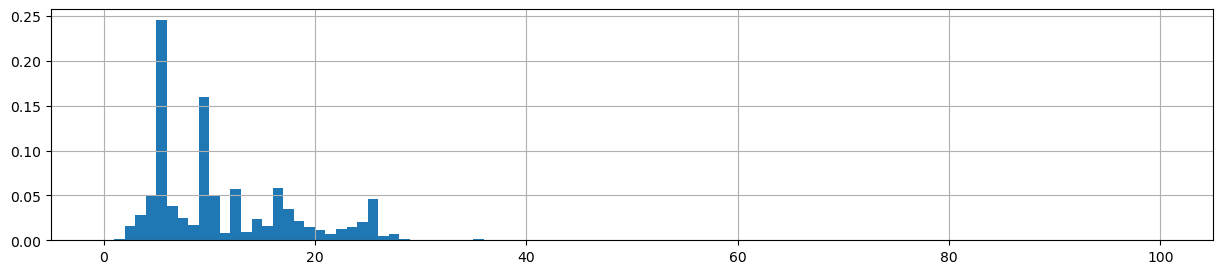

In [311]:
data.floors_total.hist(bins = 100, figsize = (15,3), range = (0,100), density= 'false');


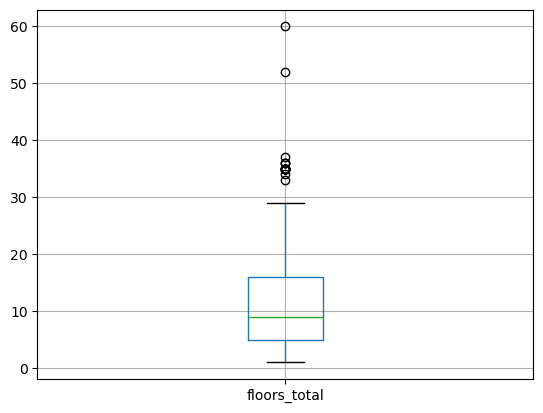

In [312]:
data.loc[:,['floors_total']].boxplot();

In [313]:
floors_total_anomalies = data['floors_total'].loc[(data['floors_total'] > 30)].count() 

floors_total_anomalies_prc = np.round(float((floors_total_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными колличеством этажей: {floors_total_anomalies} ({floors_total_anomalies_prc}%)")


Всего записей с аномальными колличеством этажей: 32 (0.1%)


In [314]:
# Пометим на удаление
idx_to_be_removed.extend(data['floors_total'].loc[(data['floors_total'] > 30)].index)

##### `floor` Этаж

In [315]:
data['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

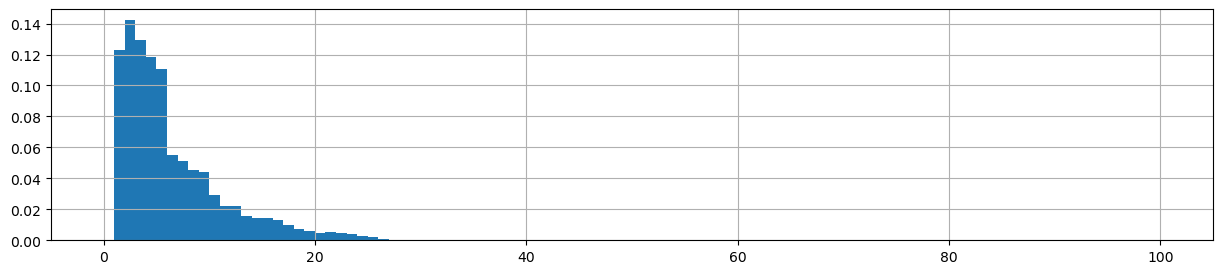

In [316]:
data.floor.hist(bins = 100, figsize = (15,3), range = (0,100), density= 'false');


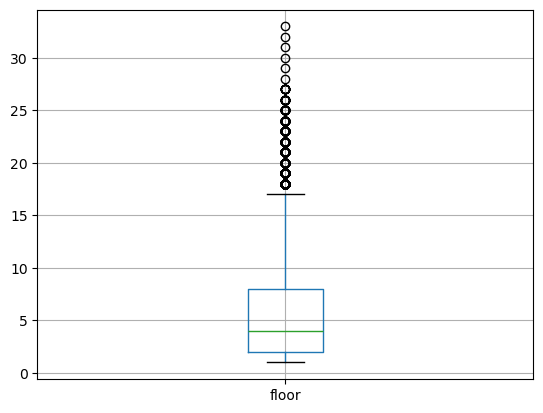

In [317]:
data.loc[:,['floor']].boxplot();

In [318]:
floor_anomalies = data['floor'].loc[(data['floor'] > 30)].count() 

floor_anomalies_prc = np.round(float((floor_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными этажем: {floor_anomalies} ({floor_anomalies_prc}%)")


Всего записей с аномальными этажем: 3 (0.0%)


In [319]:
# Пометим на удаление
idx_to_be_removed.extend(data['floor'].loc[(data['floor'] > 30)].index)

##### `rooms` Колличество комнат

In [320]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

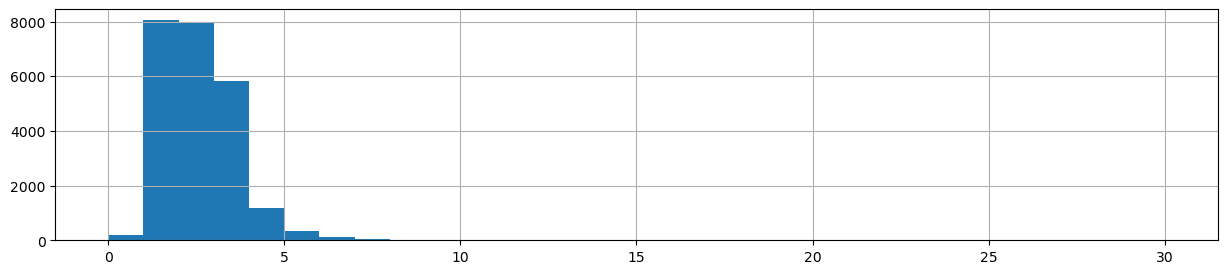

In [321]:
data.rooms.hist(bins = 30, figsize = (15,3), range = (0,30));

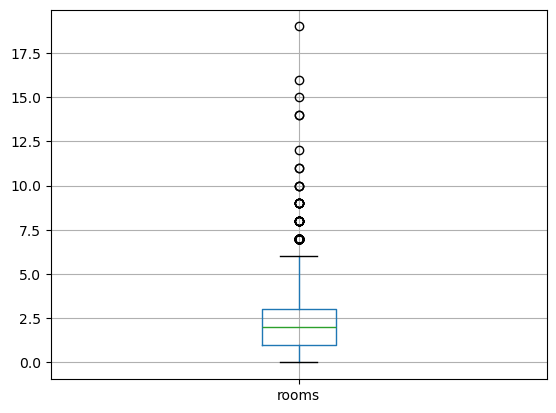

In [322]:
data.loc[:,['rooms']].boxplot();

In [323]:
rooms_anomalies = data['rooms'].loc[(data['rooms'] > 8)].count() 

rooms_anomalies_prc = np.round(float((rooms_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными количеством комнат: {rooms_anomalies} ({rooms_anomalies_prc}%)")

Всего записей с аномальными количеством комнат: 19 (0.1%)


In [324]:
# Пометим на удаление
idx_to_be_removed.extend(data['rooms'].loc[(data['rooms'] > 8)].index)

In [325]:
zero_rooms_anomalies = data['rooms'].loc[(data['rooms'] == 0 )].count() 

zero_rooms_anomalies_prc = np.round(float((zero_rooms_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными количеством комнат: {zero_rooms_anomalies} ({zero_rooms_anomalies_prc}%)")

Всего записей с аномальными количеством комнат: 197 (0.8%)


In [326]:
# Пометим на удаление
idx_to_be_removed.extend(data['rooms'].loc[(data['rooms'] == 0)].index)

##### `total_area` Общаяя площадь

**Промежуточный вывод**
Согласно СП 54.13330.2016 Здания жилые многоквартирные
        
Рекомендуемая площадь квартир, м. кв. 1 комнатная - 28-30
Не будем вдаваться в юридические аспекты и нюанся, возьмем данную характиристику за отправную точку при подготовке данных.
        

In [327]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

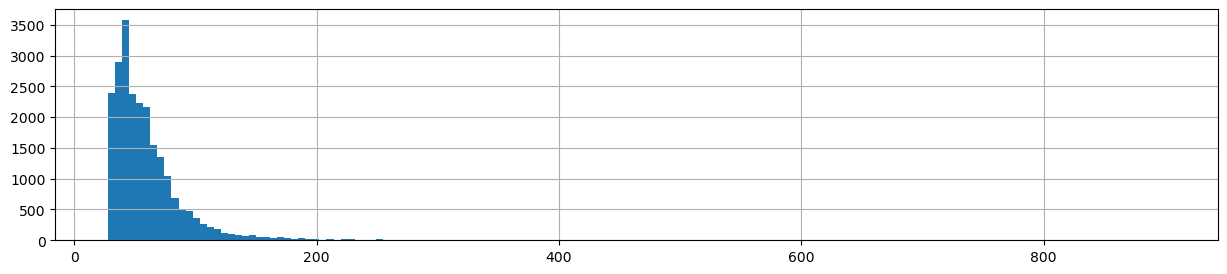

In [328]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (28,900));

<Axes: >

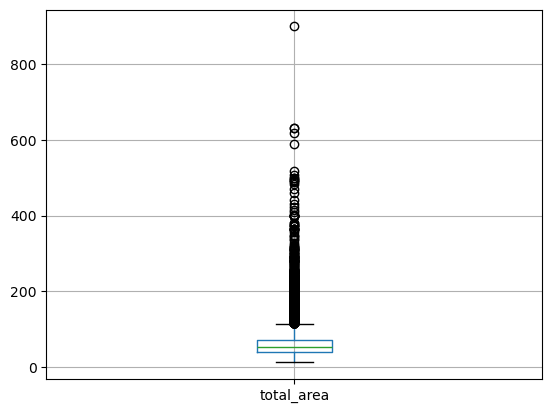

In [329]:
data.loc[:,['total_area']].boxplot() 

**Промежуточный вывод**

Для квартир общей площадью более 300 квадратных метров установим разделитель десятичной дроби, так как скорее всего ее потеряли при вводе


In [330]:
for anomaly in data.loc[(data['total_area'] > 300),'total_area'] :
    data.loc[(data['total_area'] == anomaly) ,'total_area'] = anomaly / 10

<Axes: >

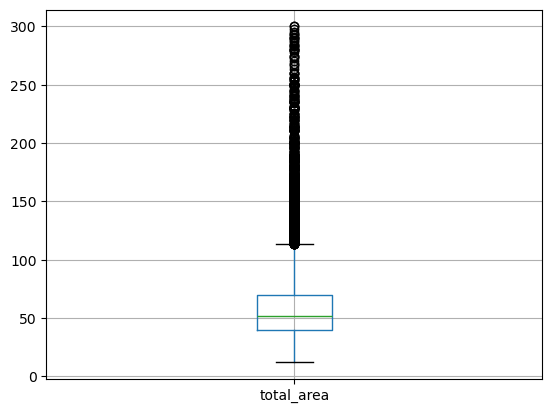

In [331]:
data.loc[:,['total_area']].boxplot() 

In [332]:
total_area_anomalies = data['total_area'].loc[(data['total_area'] <= 20)].count() 

total_area_anomaliess_prc = np.round(float((total_area_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными значениям общей рлощади: {total_area_anomalies} ({total_area_anomaliess_prc}%)")


Всего записей с аномальными значениям общей рлощади: 35 (0.1%)


In [333]:
# Пометим на удаление
idx_to_be_removed.extend(data['total_area'].loc[(data['total_area'] <=20)].index)

##### `ceiling_height` высота потолков (м)

**Промежуточный вывод**

~40% пропусков довольно внушительная цифра. В данном случае, для квартир в которых высота потолков не указанна, примем допущение, что высота потолка более менее будет одиннаковой для всех квратир с одиннаковым количеством комнат. Для вусех квартир с незаполненым значением `высота потолка` заполним медианным значением высоты потолка среди всех квартир с таким же колиечеством комнат.


In [334]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [335]:
rooms_array = data['rooms'][~data['rooms'].isna()].astype('int').sort_values().unique()

for rooms in rooms_array:
    median_rooms_height = data['ceiling_height'][(data['rooms']==rooms) & (~data['ceiling_height'].isna())].median()
    #print(median_rooms_height)
    
    data.loc[(data['rooms'] == rooms) & (data['ceiling_height'].isna()),'ceiling_height'] = median_rooms_height
    

In [336]:
data['ceiling_height'].describe()

count    23698.000000
mean         2.722539
std          0.989714
min          1.000000
25%          2.600000
50%          2.640000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [337]:
na_column = data['ceiling_height'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('ceiling_height'), data.columns[5], f'{na_column}', f'{na_percent}'))


5   ceiling_height                 1                    0.0                 


**Промежуточный вывод**

0% отлично. Все пропуски заполнены


###### Проверим выбросы

In [338]:
data['ceiling_height'].describe()

count    23698.000000
mean         2.722539
std          0.989714
min          1.000000
25%          2.600000
50%          2.640000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

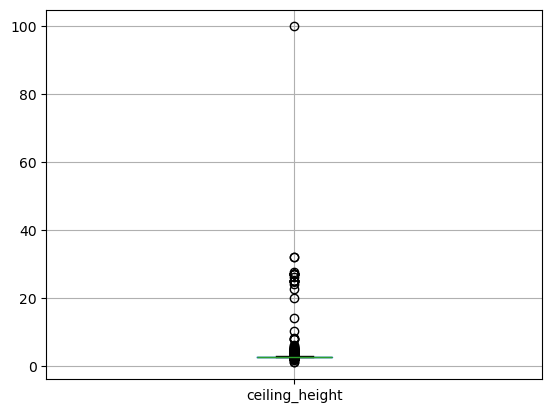

In [339]:
data.loc[:,['ceiling_height']].boxplot();

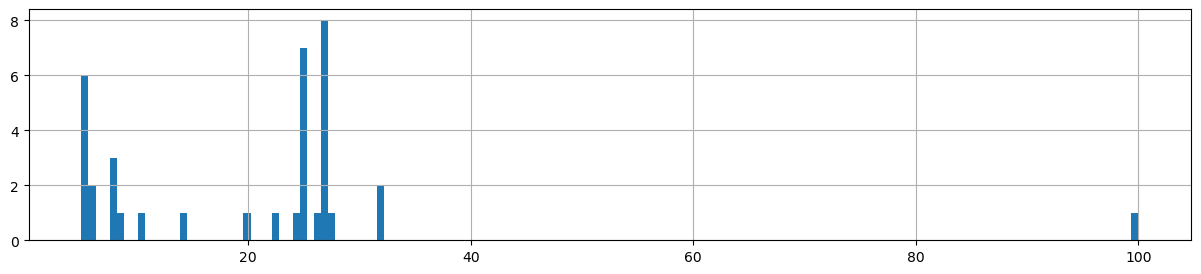

In [340]:
# Проверим сколько у нас квартир у которых высота потолка выше 5 метров
data.ceiling_height.hist(bins = 150, figsize = (15,3), range = (5,100));

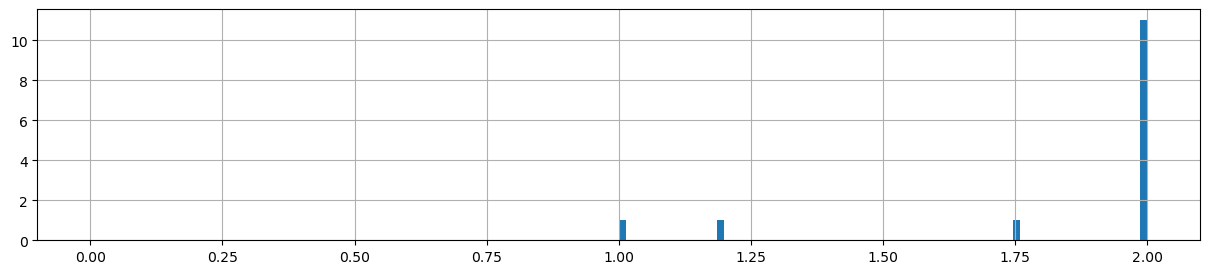

In [341]:
# Проверим сколько у нас квартир у которых высота потолка менее 2.5 метров
data.ceiling_height.hist(bins = 150, figsize = (15,3), range = (0,2));

**Промежуточный вывод**

Для потолков от 20 метров установим разделитель десятичной дроби, так как скорее всего ее потеряли при вводе


<Axes: >

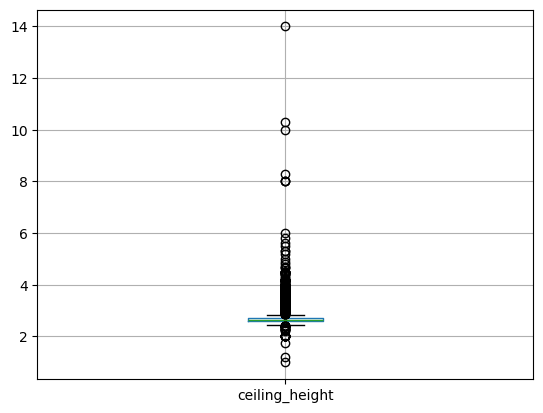

In [342]:
for anomaly in data.loc[(data['ceiling_height'] >= 20),'ceiling_height'] :
    data.loc[(data['ceiling_height'] == anomaly) ,'ceiling_height'] = anomaly / 10
    
data.loc[:,['ceiling_height']].boxplot() 

###### Обработка аномалий `ceiling_height`


In [343]:
ceiling_height_anomalies = data['ceiling_height'].loc[(data['ceiling_height'] > 4.5)].count() + \
                           data['ceiling_height'].loc[(data['ceiling_height'] <= 2)].count()

ceiling_height_anomalies_prc = np.round(float((ceiling_height_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными значениям высоты потолока: {ceiling_height_anomalies} ({ceiling_height_anomalies_prc}%)")


Всего записей с аномальными значениям высоты потолока: 35 (0.1%)


In [344]:
# Пометим на удаление
idx_to_be_removed.extend(data['ceiling_height'].loc[(data['ceiling_height'] > 4.5)].index)
idx_to_be_removed.extend(data['ceiling_height'].loc[(data['ceiling_height'] <= 2)].index)

##### `floors_total` всего этажей в доме

**Промежуточный вывод**

~0.4% процента пропусков. К сожалению определить с адекватной долей достоверности данное значение по тем данным которые у нас имеются - невозможно. Считаю что с данными пропусками можно смериться и они незначительны для целей нашего исследования


data['floors_total'] = data['floors_total'].fillna(-999)

data.loc[:,['ceiling_height']].boxplot();

In [345]:
floors_total_prc = np.round(float((len(data.loc[(data['floors_total'].isna())]) * 100) / len(data)), decimals = 1)

print(f"Всего записей с отсутствующей информацие о этажности дома: {len(data.loc[(data['floors_total'].isna())])} ({floors_total_prc}%)")


Всего записей с отсутствующей информацие о этажности дома: 86 (0.4%)


In [346]:
# 0.4% не так много, внесем индексы этих записей  в массив для последующего удаления
idx_to_be_removed.extend(data['floors_total'].loc[data['floors_total'].isna()].index)

##### `kitchen_area`

In [347]:
# 1. Разберемся с аномалиями в площади кухни когда она имеет отрицательное значение.
#    Такие аномалии заполним медианными значениями площадей кухни у которых общая 
#    площадь такая же как и в случае кухни с отрицательноё площадью

for anomaly in data.loc[(data['kitchen_area'] < 0)].index :     
    data.loc[(data.index == anomaly),'kitchen_area'] = data.loc[(data['total_area']) == data.loc[(data.index == anomaly),'total_area'].iloc[0],'total_area'].median()
     

In [348]:
# 2. Разберемся с аномалиями в площади кухни когда она больше общей площади.
#    Похоже, что такие аномалии не содержат десятичную часть. Поэтому добавим ее
for anomaly in data.loc[(data['kitchen_area'] >  data['total_area'])].index :
    data.loc[(data.index == anomaly),'kitchen_area'] = data.loc[(data.index == anomaly),'kitchen_area'].iloc[0] / 10


In [349]:
# 3. Расчитаем пропуски в  Kitchen_Area как результат разницы между total_area и living_area
na_column = data['kitchen_area'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)

print('До обработки:')
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('kitchen_area'), 
                                 data.columns[12], 
                                 f'{na_column}', 
                                 f'{na_percent}'
                                )
     )

data.loc[(data['kitchen_area'].isna()) & 
         (~data['living_area'].isna()) &
         (data['living_area'] < data['total_area']),
         'kitchen_area'] = data['total_area'] - data['living_area']

na_column = data['living_area'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)

print('После обработки:')
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('kitchen_area'), 
                                 data.columns[12], 
                                 f'{na_column}', 
                                 f'{na_percent}'))



До обработки:
12  kitchen_area                   2278                 9.61                
После обработки:
12  kitchen_area                   1903                 8.03                


In [350]:
# Остальные аномалии удалим
living_area_anomalies_prc = np.round(float((len(data.loc[(data['kitchen_area'] > 50)]) * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномалиями жилой площади: {len(data.loc[(data['kitchen_area'] > 50 )])} ({living_area_anomalies_prc}%)")


Всего записей с аномалиями жилой площади: 57 (0.2%)


In [351]:
idx_to_be_removed.extend(data.loc[(data['kitchen_area'] > 50)].index)

In [352]:
living_area_anomalies_prc = np.round(float((len(data.loc[(data['kitchen_area'] < 4)]) * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномалиями жилой площади: {len(data.loc[(data['kitchen_area'] < 4 )])} ({living_area_anomalies_prc}%)")


Всего записей с аномалиями жилой площади: 54 (0.2%)


In [353]:
idx_to_be_removed.extend(data.loc[(data['kitchen_area'] < 4)].index)

##### `living_area`

In [354]:
# 2. Разберемся с аномалиями в жилой площади.
#    Рассмотрим случаи, когда жилая площадь превышает значение общей площади .
#    Для таких аномалий, расчитаем значение жилой площади как разницу между общей площадью и площадью кухни,
#    при условии что площадь кухни не отрицательное значение

for anomaly in data.loc[(data['living_area'] > data['total_area']) & 
                        (data['kitchen_area'] < data['total_area'])]:
    
    data.loc[(data.index == anomaly),'living_area'] = data.loc[(data.index == anomaly),'total_area'] - \
                                                      data.loc[(data.index == anomaly),'kitchen_area']
    
    #print(data.loc[(data.index == anomaly),'living_area'])

#print(data.loc[(data['living_area'] > data['total_area']) & 
#                        (data['kitchen_area'] < data['total_area']) ])    

In [355]:
# 2. Разберемся со случаями когда жилая площадь не заполнена.
#    Расчитаем значение Living_Area как разницу между total_area и kitchen_area
#    Стоит отметить что Total_area пропусков не имеет

na_column = data['living_area'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)

print('До обработки:')
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('living_area'), 
                                 data.columns[7], 
                                 f'{na_column}', 
                                 f'{na_percent}'
                                )
     )

data.loc[(data['living_area'].isna()) & 
         (~data['kitchen_area'].isna()),
         'living_area'] = data['total_area'] - data['kitchen_area']

na_column = data['living_area'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)

print('После обработки:')
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('living_area'), 
                                 data.columns[7], 
                                 f'{na_column}', 
                                 f'{na_percent}'
                                )
     )

До обработки:
7   living_area                    1903                 8.03                
После обработки:
7   living_area                    1464                 6.18                


In [356]:
# Остальные аномалии удалим
living_area_anomalies_prc = np.round(float((len(data.loc[(data['living_area'] < 5)]) * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномалиями жилой площади: {len(data.loc[(data['living_area'] < 5)])} ({living_area_anomalies_prc}%)")


Всего записей с аномалиями жилой площади: 6 (0.0%)


In [357]:
idx_to_be_removed.extend(data.loc[(data['living_area'] < 5)].index)

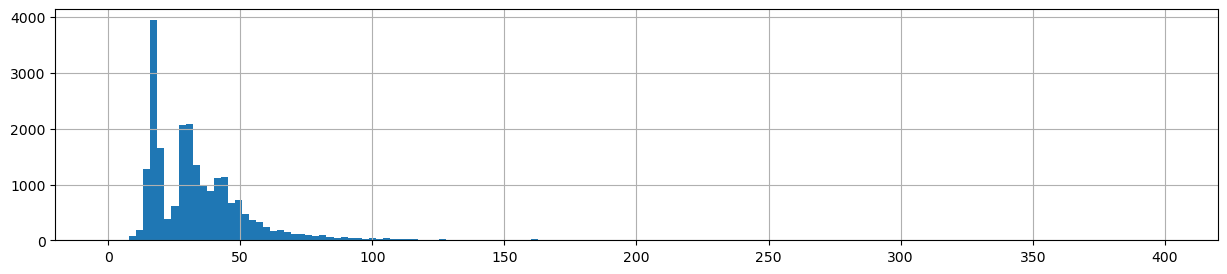

In [358]:
# Проверим результаты
data.living_area.hist(bins = 150, figsize = (15,3), range = (0,400));

###  Работа с оставшимися пропусками в обоих случаях `kitchen_area` + `living_area` 

**Промежуточный вывод**

Заполним отсутствующую информацию медианными значениями, через коэфициент, отражающий медианную долю кухни/жилой площади в общей площади квартиры.



In [359]:
#Коэф. доли жилой площади в общей площади квартиры (рассчитанный по медианным значениям):
k_median_living_area = data['living_area'].median() / data['total_area'].median()
#Применяем коэф для заполнения пропусков
data['living_area'] = data['living_area'].fillna(k_median_living_area*data['total_area'])

#Коэф. доли площади кухни в общей площади квартиры (рассчитанный по медианным значениям):
k_median_kitchen_area = data['kitchen_area'].median() / data['total_area'].median()
#Применяем коэф для заполнения пропусков
data['kitchen_area'] = data['kitchen_area'].fillna(k_median_kitchen_area*data['total_area'])

In [360]:
# Проверим оставшиеся пропуски
na_column = data['living_area'].isna().sum()
na_percent = (100 * na_column / len(data)).round(2)
print('%-3s %-30s %-20s %-20s'% (data.columns.get_loc('kitchen_area'), data.columns[12], f'{na_column}', f'{na_percent}'))


12  kitchen_area                   0                    0.0                 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


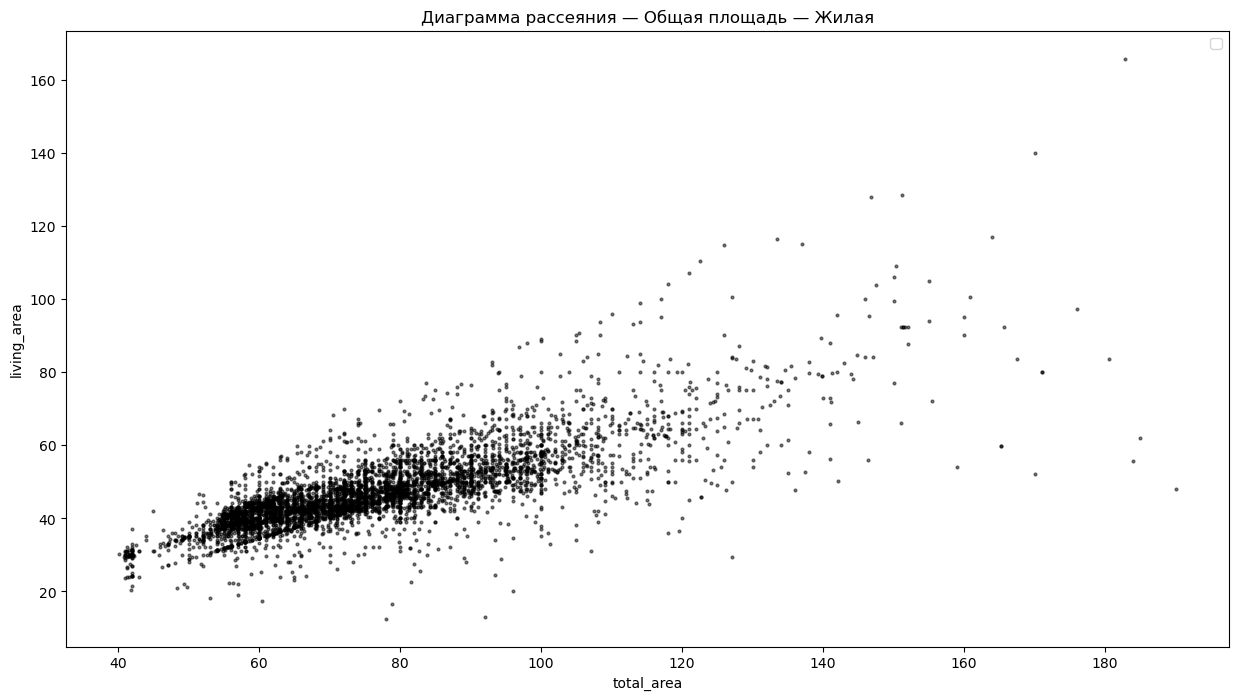

In [361]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

##### `is_apartment`

**Промежуточный вывод**

Разницу между апартаментами и обычной квратирой понимают правильно даже не все юристы, тем более что термин апартаменты достаточно плохо определен. Поэтому будем считать что все кто заполнили данное поле знают наверняка что они продают апаты, в то время как те кто не заполнили это поле - явно его пропустили так как скорее всего к их вариантам это не применимо иначе они бы знали точно. Поэтому заполним все пропуски False


In [362]:
data['is_apartment'] = data['is_apartment'].fillna(False)

##### `balcony`

**Промежуточный вывод**

Очевидно, в данном случае пропуск означает отсутствие балкона, так как его наличие является преемуществом, следовательно если продавец явно не указал эту информацию, то балкона просто нет. Заполним все пропуски 0


In [363]:
data['balcony'] = data['balcony'].fillna(0)

In [364]:
data['balcony'].describe()

count     23699.0
mean      0.59108
std      0.959298
min           0.0
25%           0.0
50%           0.0
75%           1.0
max           5.0
Name: balcony, dtype: Float64

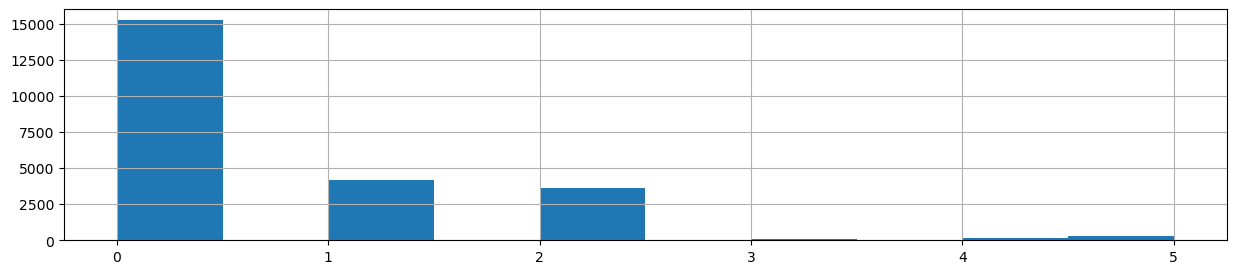

In [365]:
# Проверим результаты
data.balcony.hist(bins = 10, figsize = (15,3), range = (0,5));

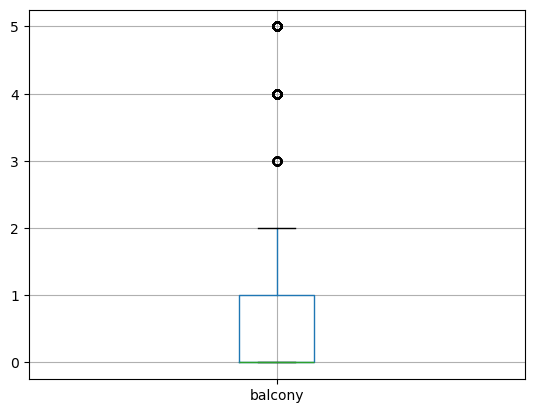

In [366]:
data.loc[:,['balcony']].boxplot();

In [367]:
total_balcony_anomalies = data['balcony'].loc[(data['balcony'] > 3)].count() 

total_balcony_anomalies_prc = np.round(float((total_balcony_anomalies * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномальными количеством балконов: {total_balcony_anomalies} ({total_balcony_anomalies_prc}%)")

Всего записей с аномальными количеством балконов: 487 (2.1%)


##### `locality_name`

In [368]:
# Сделаем базовую предобработку. Приведем все к нижнему регистру, удалим пробелы и отработаем букву ё
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.strip()
data['locality_name'] = data['locality_name'].str.replace("ё", "е", 2)
data['locality_name'] = data['locality_name'].str.replace("городской поселок мга", "поселок городского типа мга")

# Посмотрим сколько у нас уникальных названий населенных пунктов
print(f"Всего уникальных наименований локаций: {len(data['locality_name'].unique())}")
print(f"Всего записей с отсутствующей информацие о локации: {len(data.loc[(data['locality_name'].isna())])}")



Всего уникальных наименований локаций: 330
Всего записей с отсутствующей информацие о локации: 49


In [369]:
# Внесем индексы записей с отсутсвующей информации о локации в массив для последующего удаления
idx_to_be_removed.extend(data['locality_name'].loc[data['locality_name'].isna()].index)

##### days_exposition

In [370]:
# Проверим сколько у нас объявлений в которых колличество дней объявления менее 50
days_exposition_anomalies_prc = np.round(float((len(data.loc[(data['days_exposition'] < 5)]) * 100) / len(data)), decimals = 1)

print(f"Всего записей с аномалиями сроков продажи: {len(data.loc[(data['days_exposition'] < 5 )])} ({days_exposition_anomalies_prc}%)")


Всего записей с аномалиями сроков продажи: 338 (1.4%)


In [371]:
idx_to_be_removed.extend(data.loc[(data['days_exposition'] < 5)].index)

Проверим сколько у нас объявлений с незаполненной датой days_exposition

In [372]:
data['days_exposition'].isna().sum()


3181

**Промежуточный вывод**

Скорее всего, отсутствие данных в этом столбце означает, что данный показатель не может быть рассчитан, поскольку объявление о продаже еще не снято. Поэтому пропуски в этом столбце оставим как есть

In [373]:
# check
data.locality_name.nunique()

329

In [374]:
# check
data.locality_name.unique()


array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет

##### `Расстояние до ближайших объектов`

**Промежуточный вывод**


Обратим внимание на тот факт что незаполненость данных о расстояних до инфраструктурных объектах идентичная
Есть гипотеза что это означает что есть строки в которых эта информация полностью отсутствут. Проверим


In [375]:
len(data['locality_name'].loc[( (data['num_of_parks_around_3000m'].isna())&
                                (data['distance_to_nearest_park'].isna())&
                                (data['num_of_ponds_around_3000m'].isna())&
                                (data['distance_to_nearest_pond'].isna())&
                                (data['distance_to_downtown'].isna())&
                                (data['distance_to_nearest_airport'].isna())
                              )])

5518

**Промежуточный вывод**

Да так и есть. Но с другой стороны хоть строк не содержащих ни какой информации о доступных объектах инфраструктуры много, тем не мене удалять их нельзя так как это очевидно смажет исследование но можно и не беспокоится о пропусках так как они не важны для целей нашего исследования


##### `first_day_exposition`

##### РЕЗУЛЬТАТЫ

In [376]:
# Проверим, сколько всего строк мы собираемся удалить из датафрейма по результатам предобработки:

print('Всего помечено "на удаление" строк:', len(pd.Series(idx_to_be_removed).unique()))
testdatalost(len(pd.Series(idx_to_be_removed).unique()))

Всего помечено "на удаление" строк: 1182
Допустимые потери



In [377]:
to_be_removed_count = len(pd.Series(idx_to_be_removed).unique())

to_be_removed_prc = np.round(float((to_be_removed_count * 100) / len(data)), decimals = 1)

print(f"Всего записей помеченных на удаление: {to_be_removed_count} ({to_be_removed_prc}%)")


Всего записей помеченных на удаление: 1182 (5.0%)


**Промежуточный вывод**

Количество помеченных строк незначительно. Однако избавившись от них, мы значительно повысим качество данных для анализа. Итоговый датафрейм будет очищен от статистических выбросов, аномалий и пропущенных значений.

Запишем датафрейм с удаленными в результате предобработки строками, в переменную `data_cleaned`. Исходный датафрейм `data` приведем к изначальному виду. Это позволит нам при необходимости обращаться к сравнению данных до и после предобработки, чтобы оценить качество проделанной работы по предобработке данных.

In [378]:
data.query('kitchen_area < 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,distance_to_nearest_airport,distance_to_downtown,num_of_parks_around_3000m,distance_to_nearest_park,num_of_ponds_around_3000m,distance_to_nearest_pond,days_exposition


In [379]:
data_cleaned = data
data_cleaned.drop(labels = idx_to_be_removed, axis = 0, inplace = True)

#Сбрасываем индексы в датафрейме (исходные индексы запишем в отдельный столбец):
data_cleaned.reset_index(drop=False, inplace=True)

#Перезапишем исходный датафрейм для сравнения:
data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')

#Столбец с количеством фотографий в дальнейшем анализе нам не понадобится. Он лишний - удалим его:
data = data.drop(['total_images'], axis='columns')
data_cleaned = data_cleaned.drop(['total_images'], axis='columns')

In [380]:
#Посмотрим еще (после удаления) раз на типы данных в столбцах нашего датафрейма:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22517 entries, 0 to 22516
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        22517 non-null  int64         
 1   last_price                   22517 non-null  float64       
 2   total_area                   22517 non-null  float64       
 3   first_day_exposition         22517 non-null  datetime64[ns]
 4   rooms                        22517 non-null  int64         
 5   ceiling_height               22517 non-null  float64       
 6   floors_total                 22517 non-null  Int64         
 7   living_area                  22517 non-null  float64       
 8   floor                        22517 non-null  int64         
 9   is_apartment                 22517 non-null  bool          
 10  is_studio                    22517 non-null  bool          
 11  is_open_plan                 22517 non-nu

**Промежуточный вывод**

Как мы видим, из датафрейма исчезло 214 строк (как и планировалось), что составляет меньше 2% от общего количества строк. 

Типы данных во всех столбцах соответствуют содержащейся в них информации.

Проверим, не осталось ли в датафрейме пропущенных значений:

In [381]:
#Посмотрим, в каких столбцах датафрейма есть пропуски и оценим их количество, абсолютное и относительное:
n = 0
for column in data_cleaned.columns:
    if data_cleaned[column].isna().sum() > 0:
        na = data_cleaned[column].isna().sum()
        print('%-25s %-20s %-20.3f' % (data_cleaned.columns[n], f'isna() {na}', (100*na/len(data_cleaned))))
    n += 1

distance_to_nearest_airport isna() 5136          22.809              
distance_to_downtown      isna() 5115          22.716              
num_of_parks_around_3000m isna() 5114          22.712              
distance_to_nearest_park  isna() 14799         65.724              
num_of_ponds_around_3000m isna() 5114          22.712              
distance_to_nearest_pond  isna() 13867         61.585              
days_exposition           isna() 3055          13.568              


In [382]:
# check
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22517 entries, 0 to 22516
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        22517 non-null  int64         
 1   last_price                   22517 non-null  float64       
 2   total_area                   22517 non-null  float64       
 3   first_day_exposition         22517 non-null  datetime64[ns]
 4   rooms                        22517 non-null  int64         
 5   ceiling_height               22517 non-null  float64       
 6   floors_total                 22517 non-null  Int64         
 7   living_area                  22517 non-null  float64       
 8   floor                        22517 non-null  int64         
 9   is_apartment                 22517 non-null  bool          
 10  is_studio                    22517 non-null  bool          
 11  is_open_plan                 22517 non-nu

In [383]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data_cleaned[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,517.00","22,517.00","22,517.00","19,462.00","22,517.00","22,517.00","22,517.00","22,517.00","22,517.00"
min,1.00,20.10,2.20,5.00,"1,000,000.00",5.40,3.59,1.00,1.00
max,8.00,297.50,4.50,"1,580.00","50,000,000.00",332.00,52.76,27.00,29.00


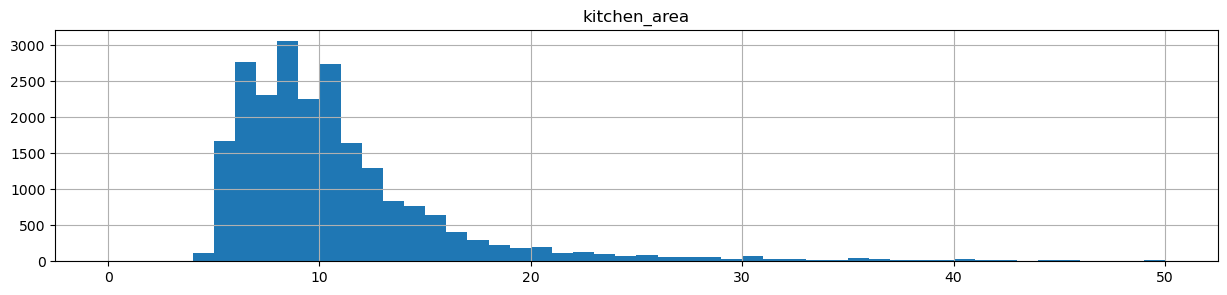

In [384]:
# check
data_cleaned.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (0,50));

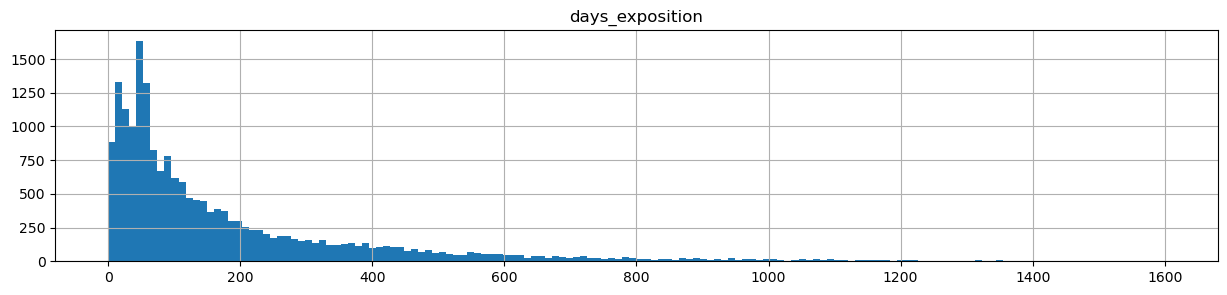

In [385]:
# check
data_cleaned.hist(column = 'days_exposition', bins = 150, figsize = (15,3), range = (0,1600));

#data_cleaned.hist(column = 'days_exposition', bins = 150, figsize = (15,3), range = (4,2000))
#plt.ylim(0, 140);

In [386]:
# check
df_check.rooms.value_counts().to_frame()

,count
rooms,
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12


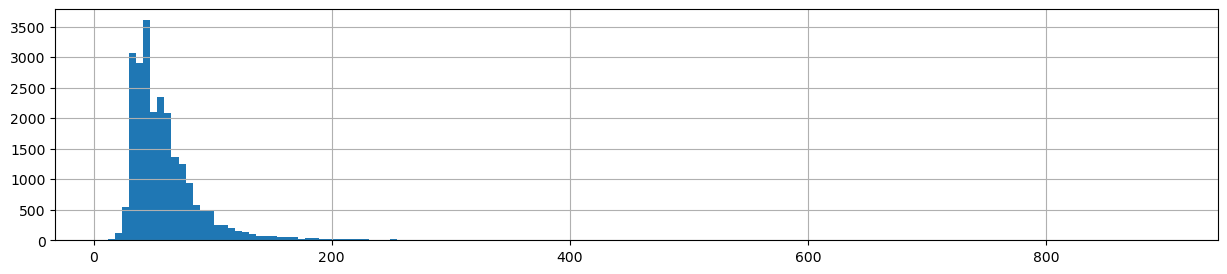

In [387]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

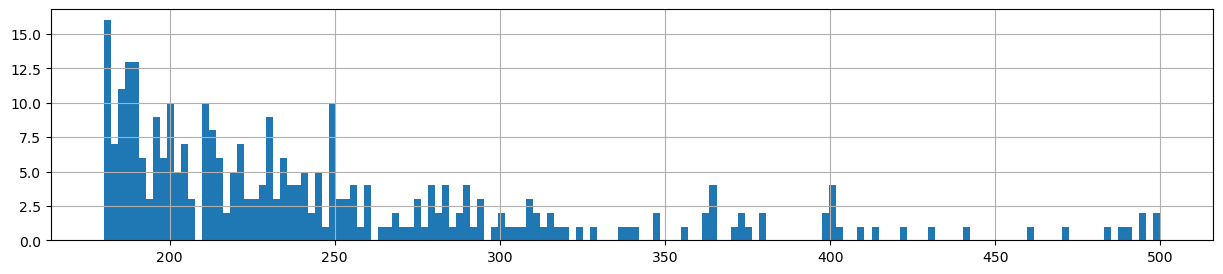

In [388]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

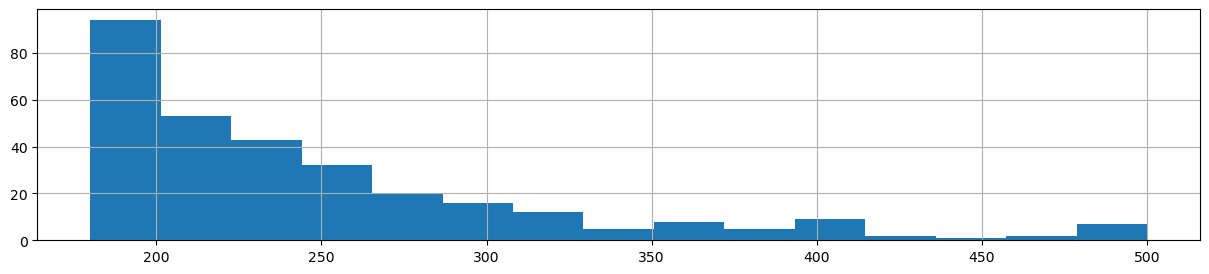

In [389]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

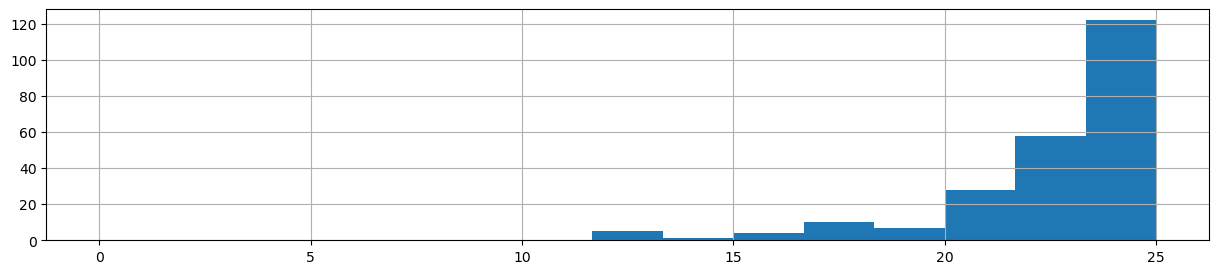

In [390]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [391]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data_cleaned[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,1.00,22.00,2.40,5.00,"1,050,000.00",10.00,4.00,1.00,2.00
0.010000,1.00,28.00,2.50,6.00,"1,300,000.00",13.21,5.00,1.00,2.00
0.500000,2.00,52.00,2.64,98.00,"4,675,000.00",30.20,9.30,4.00,9.00
0.990000,5.00,170.00,3.54,"1,074.39","27,928,224.00",108.40,35.00,22.00,26.00
0.998800,7.00,240.00,4.10,"1,374.29","45,000,000.00",174.99,46.00,25.98,27.00


### Расчитаем и добавим в таблицу новые столбцы

**Цена за квадратный метр**

In [392]:
data_cleaned['sqm_cost'] = data_cleaned['last_price'] / data['total_area'] /1000
data_cleaned['sqm_cost'].describe()

count    22517.000000
mean       120.645831
std        113.597534
min          2.400000
25%         58.441558
50%         90.476190
75%        141.304348
max       1609.677419
Name: sqm_cost, dtype: float64

**День недели публикации объявления, месяц и год**

In [393]:
data_cleaned['day'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.weekday
data_cleaned['month'] = data_cleaned['first_day_exposition'].dt.month
data_cleaned['year'] = data_cleaned['first_day_exposition'].dt.year

**Тип этажа квартиры**

In [394]:
floor_type = []
#Наполняем список категориальными значениями будущего столбца:
for index in range(data_cleaned['floor'].count()):
    if data_cleaned['floor'][index] == 1:
        floor_type.append('первый')
    elif data_cleaned['floor'][index] == data['floors_total'][index]:
        floor_type.append('последний')
    else:
        floor_type.append('другой')

#Добавляем столбец в датафрейм:
data_cleaned.insert(9, 'floor_type', floor_type, False)

In [395]:
#Проверим результат:
data_cleaned.loc[:13,['floor_type','floor','floors_total']]

,floor_type,floor,floors_total
0,другой,8,16
1,первый,1,11
2,другой,4,5
3,другой,13,14
4,другой,5,12
5,другой,6,26
6,другой,22,24
7,другой,26,27
8,другой,7,9
9,другой,3,12


**Расстояние до центра города в км**

In [396]:
#Добавим в датафрейм новый столбец с расстоянием до центра города в км:
data_cleaned.insert(18, 'distance_to_downtown_km', round((data_cleaned['distance_to_downtown'] / 1000),0), False)
data_cleaned.insert(19, 'distance_to_nearest_airport_km', round((data_cleaned['distance_to_nearest_airport'] / 1000),0), False)
data_cleaned.insert(20, 'distance_to_nearest_pond_km', round((data_cleaned['distance_to_nearest_pond'] / 1000),0), False)
data_cleaned.insert(21, 'distance_to_nearest_park_km', round((data_cleaned['distance_to_nearest_park'] / 1000),0), False)

In [397]:
#Проверим результат:
data_cleaned.loc[:5,['distance_to_downtown_km','distance_to_downtown']]

,distance_to_downtown_km,distance_to_downtown
0,16.0,16028.0
1,19.0,18603.0
2,14.0,13933.0
3,8.0,8098.0
4,NaN,NaN
5,19.0,19143.0


## Проведем исследовательский анализ данных

**Total Area**

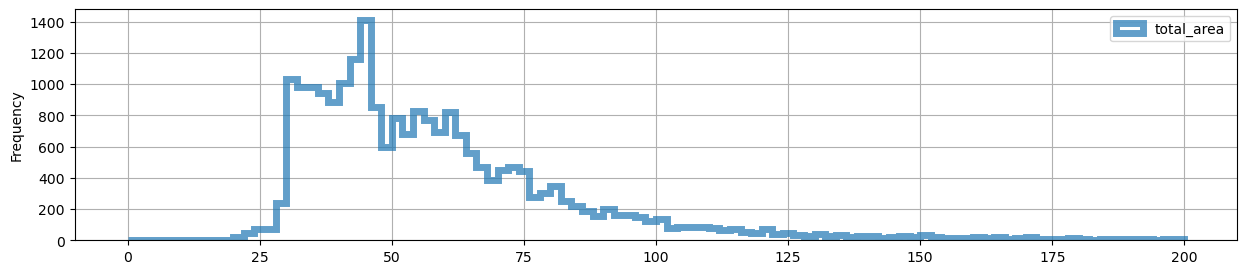

In [398]:
data_cleaned.plot(
    kind='hist',
    y='total_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='total_area',
    grid=True,
    legend=True,
    figsize = (15,3)
); 

**Промежуточный вывод**
На графике видно что самые продаваемые квартиры от 25 до 40 кв метров


**Отношение Total Area к Living Area**

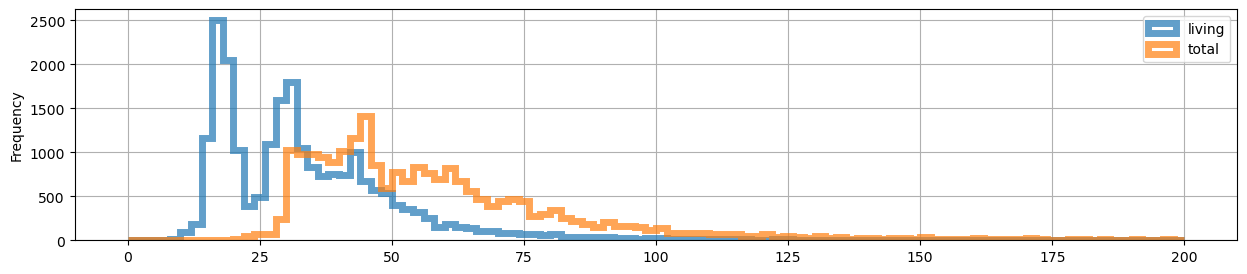

In [399]:
ax = data_cleaned.plot(
    kind='hist',
    y='living_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='living',
    figsize = (15,3)
)
data_cleaned.plot(
    kind='hist',
    y='total_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='total',
    ax=ax,
    grid=True,
    legend=True,
    figsize = (15,3)
);

**Промежуточный вывод**

На графике видно что кривые практически идентичны, но жилая площадь смещена левее, что логично, так как жилая площадь меньше общей


**Kitchen Area**

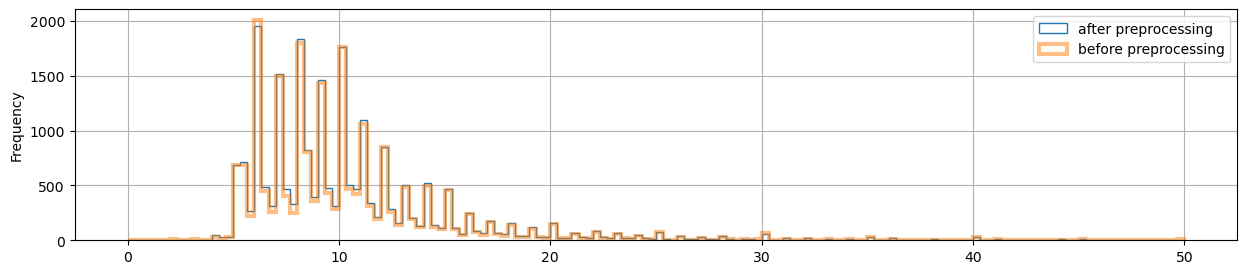

In [400]:
#Столбчатая диаграмма с данными после предобработки:
ax = data_cleaned.plot(
    kind='hist',
    y='kitchen_area',
    histtype='step',
    range=(0, 50),
    bins=150,
    linewidth=1,
    alpha=1,
    label='after preprocessing',
    figsize = (15,3)
)
#Столбчатая диаграмма с данными до предобработки:
data_orig.plot(
    kind='hist',
    y='kitchen_area',
    histtype='step',
    range=(0, 50),
    bins=150,
    linewidth=3,
    alpha=0.5,
    label='before preprocessing',
    ax=ax,
    grid=True,
    legend=True,
    figsize = (15,3)
);

**Промежуточный вывод**

На графике видно,что результаты предобработки не повлияли на форму распределения исследуемого параметра. Это значит, что основные статистические параметры совокупности остались без изменений. В то же время, заполнение пропусков позволило увеличить доступный для анализа объем данных.


**Last Price**

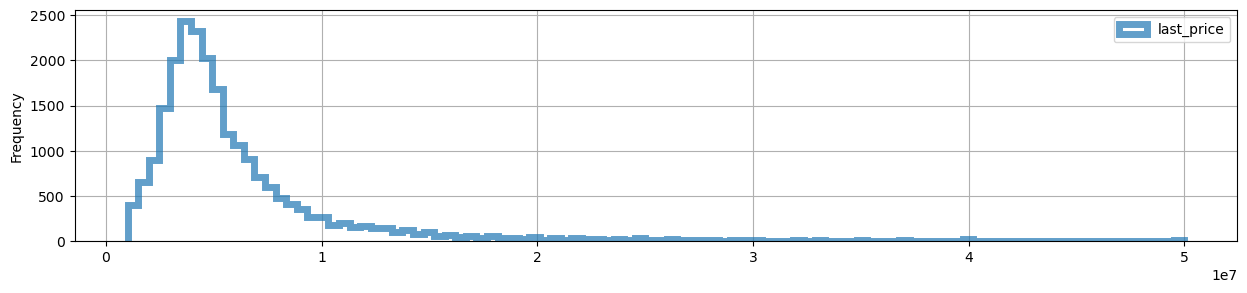

In [401]:
data_cleaned.plot(
    kind='hist',
    y='last_price',
    histtype='step',
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='last_price',
    grid=True,
    legend=True,
    figsize = (15,3)
) ;

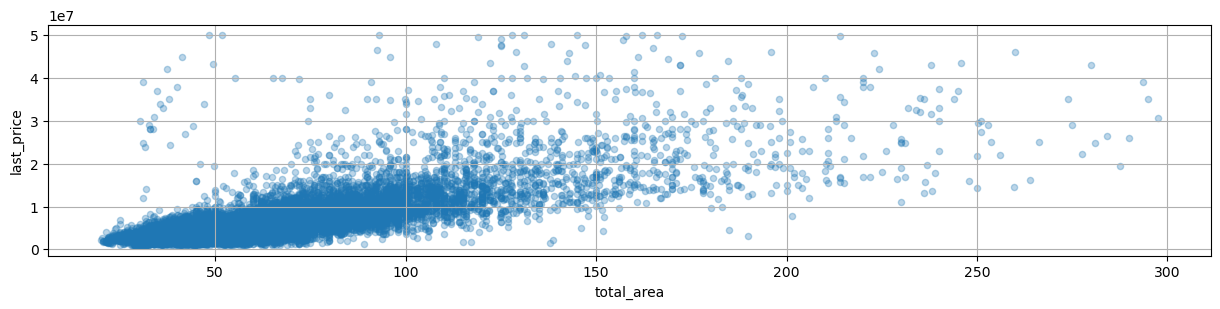

In [402]:
(data_cleaned.plot(
           x='total_area', 
           y='last_price', 
           kind='scatter', 
           grid=True, 
           alpha=0.3,
           figsize = (15,3)));

**Промежуточный вывод**
Цена объекта недвижимости тесно связана с его общей площадью, однако по мере увеличения этих параметров взаимосвязь между ними существенно слабеет.



**Rooms**

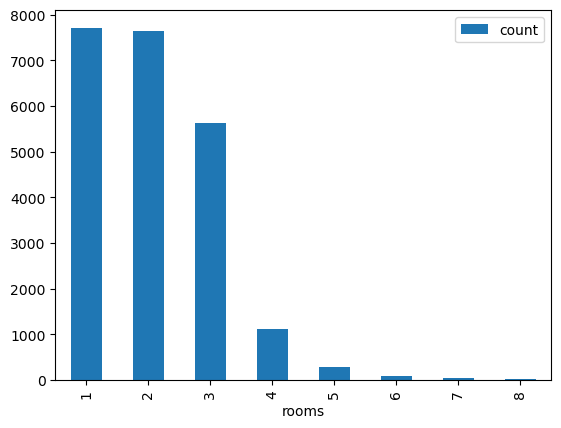

In [403]:
data_cleaned['count'] = 1
data_cleaned.pivot_table(index='rooms', values='count', aggfunc='count').plot(kind='bar');

**Промежуточный вывод**

Большая часть планировок имеет 1,2,3 реже 4 комнаты. В сумме данные планировки занимают около 90% рынка.


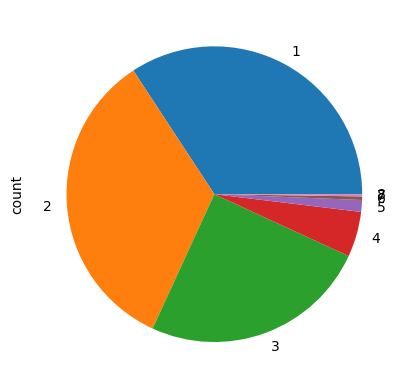

In [404]:
data_cleaned.groupby('rooms')['count'].count().plot(kind='pie');

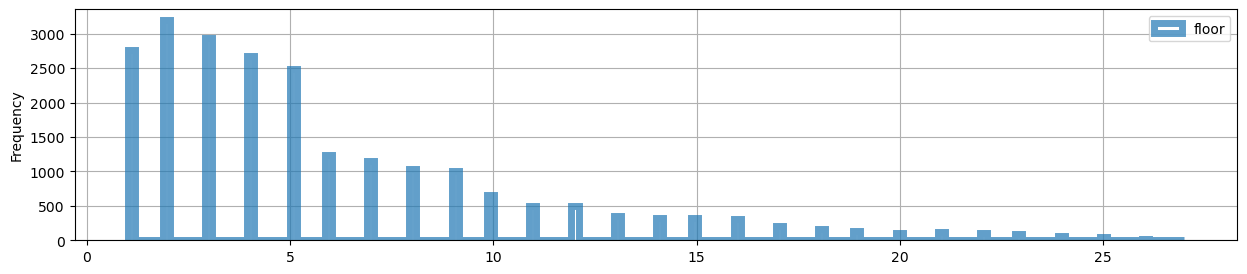

In [405]:
data_cleaned.plot(
    kind='hist',
    y='floor',
    histtype='step',
    bins=150,
    linewidth=5,
    alpha=0.7,
    label='floor',
    grid=True,
    legend=True,
    figsize = (15,3)
);

**Ceiling Height**

<Axes: >

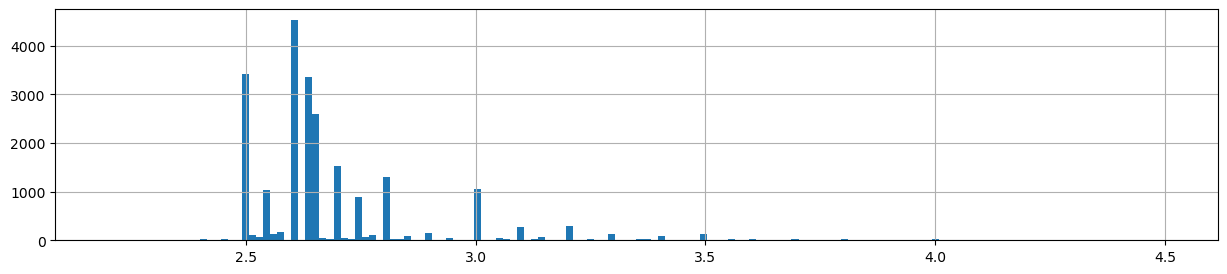

In [406]:
data_cleaned['ceiling_height'].hist(bins=150, figsize=(15, 3))

**Промежуточный вывод**

Подавляющее большинство планировок имеет высоту потолков 2,5-2.8 м. Впрочем, 2,7 - 2,8 м тоже встречается довольно часто. Отличительной особенностью Петербурга является старая застройка, с потолками выше 3 м.

**Floors**

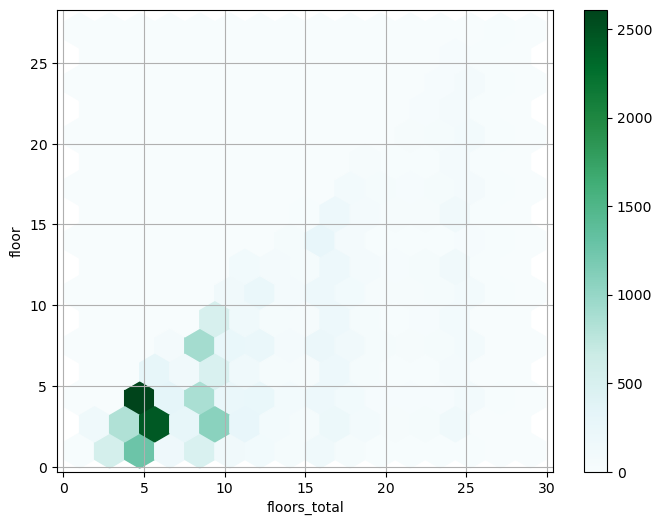

In [407]:
data_cleaned.plot(x='floors_total', y='floor', kind='hexbin', gridsize=15, figsize=(8, 6), sharex=False, grid=True) ;

**Промежуточный вывод**
Чаще всего к продаже предлагаются 1 и 2 этажи


**Floor Type**

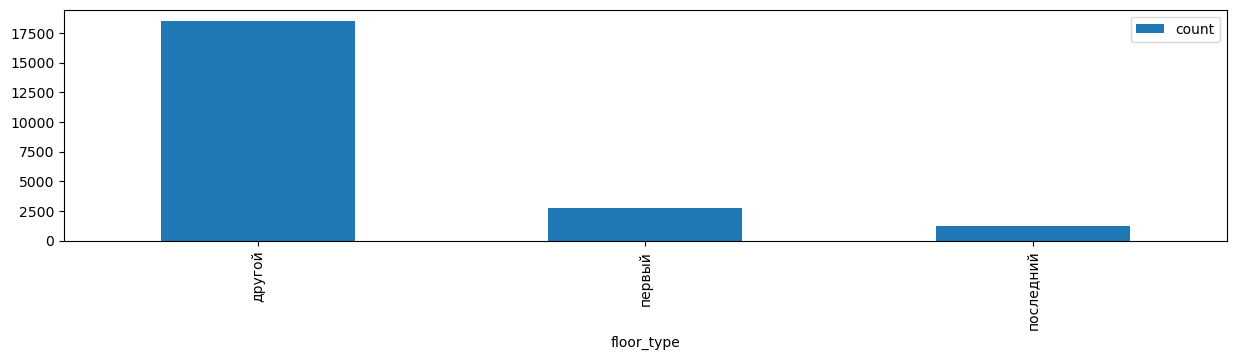

In [408]:
data_cleaned.pivot_table(index='floor_type', values='count', aggfunc='count').plot(kind='bar', figsize=(15, 3));

**Промежуточный вывод**

Первый и последний этажи состовляют примерно  10% b 5% от общего объема предложения на рынке недвижимости каждый.

**Floors Total**

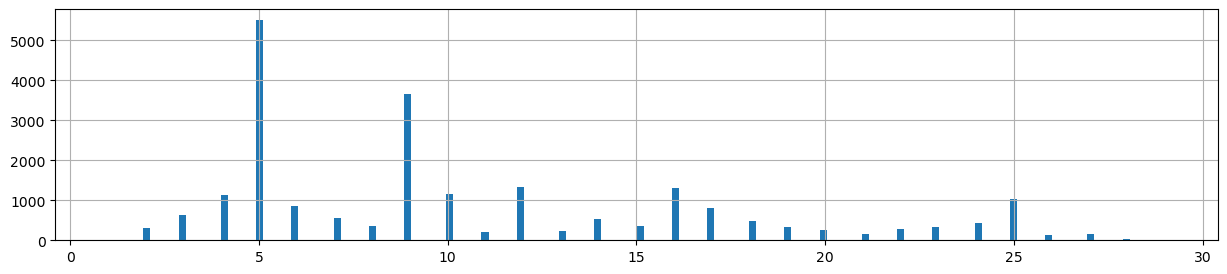

In [409]:
data_cleaned['floors_total'].hist(bins=150, figsize=(15, 3));


**Промежуточный вывод**

В основном на рынке преобладают серии домов с 5-ти и 9-ти этажной застройкой.

**Distance to downtown**

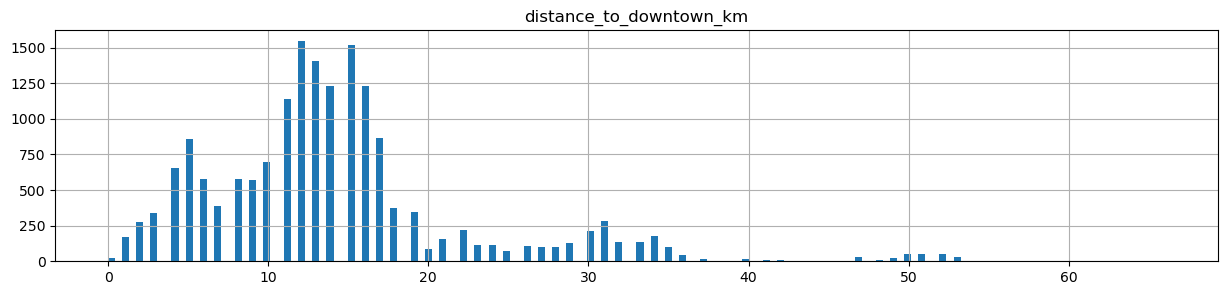

In [410]:
data_cleaned['price_type'] = pd.qcut(data['last_price'], q=10, labels=[1,2,3,4,5,6,7,8,9,10], precision=0, duplicates='drop')

data_cleaned.loc[:,['distance_to_downtown_km']].hist(bins=150,figsize=(15, 3));

**Промежуточный вывод**

На графике видно, что самая дорогая недвижимость находится на небольшом удалении от центра

**distance_to_nearest_airport**

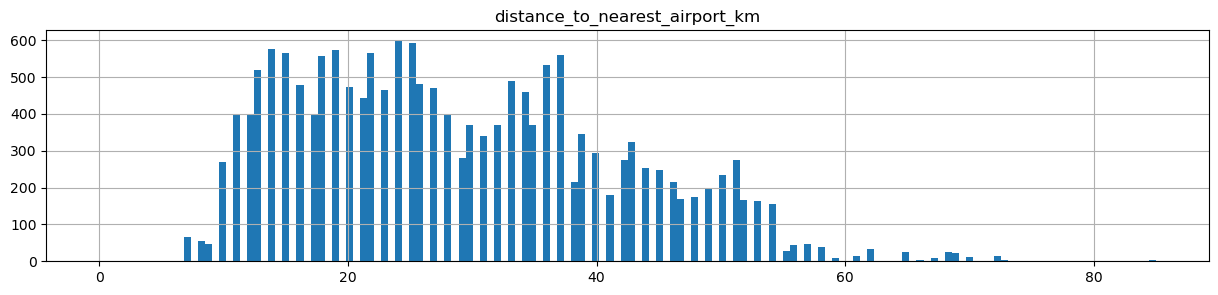

In [411]:
data_cleaned.loc[:,['distance_to_nearest_airport_km']].hist(bins=150,figsize=(15, 3));

**Промежуточный вывод**

Самая дорогая недвижимость предлагается в небольшой отдаленности от аэропорта

**distance_to_nearest_pond**

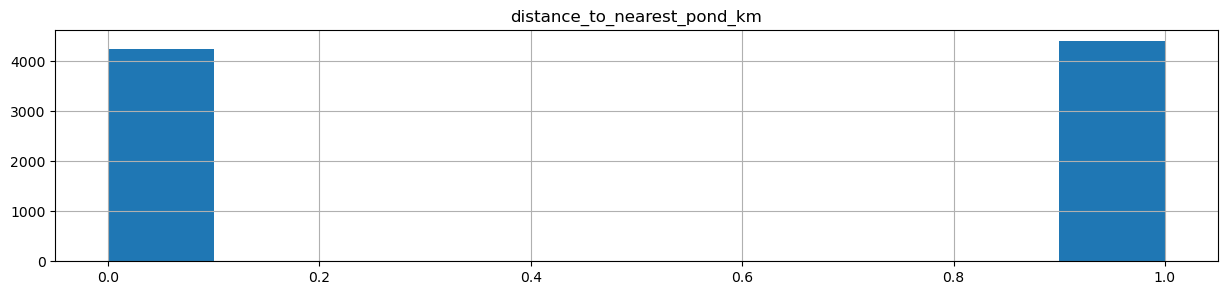

In [412]:
data_cleaned.loc[:,['distance_to_nearest_pond_km']].hist(figsize=(15, 3));

**distance_to_nearest_park**

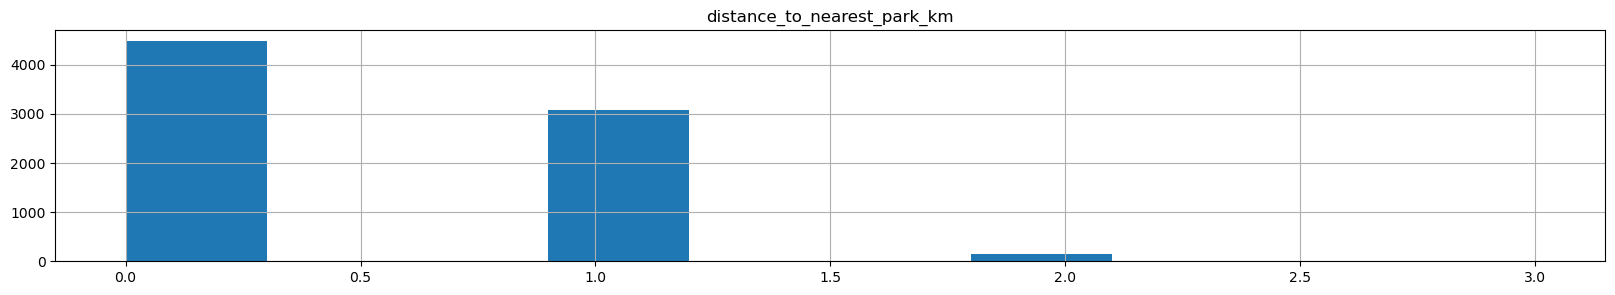

In [413]:
data_cleaned.loc[:,['distance_to_nearest_park_km']].hist(figsize=(20, 3));

**week day**

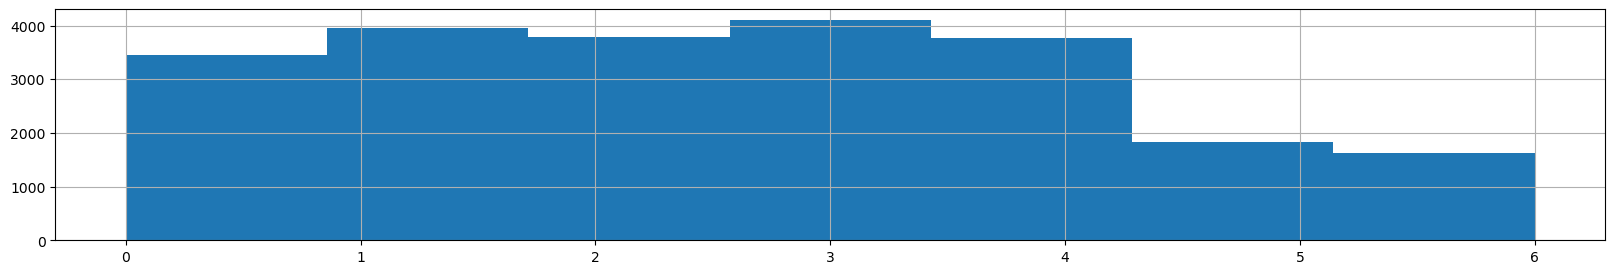

In [414]:
data_cleaned['day'].hist(bins=7,figsize=(20, 3));

**Промежуточный вывод**

Большая часть объявлений размещается в будние дни

**month**

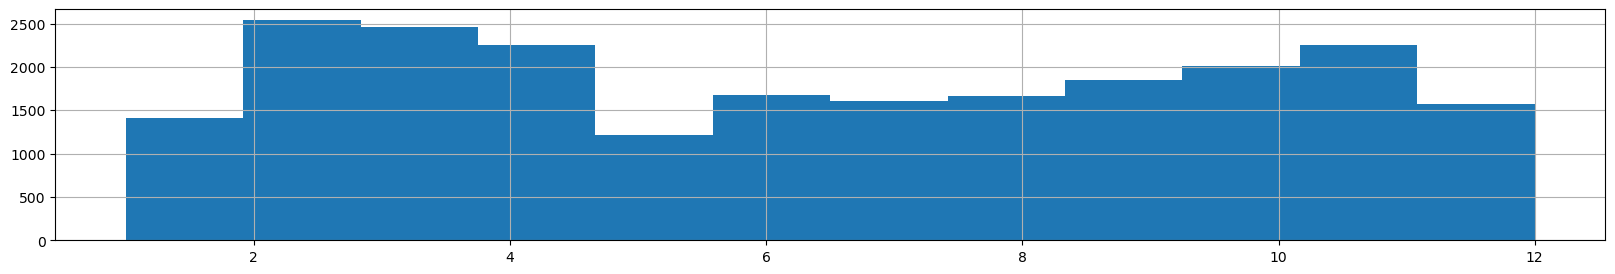

In [415]:
data_cleaned['month'].hist(bins=12,figsize=(20, 3));

**Промежуточный вывод**

Наблюдается спад объявлений о продажи недвижимости в весенне-летнее время

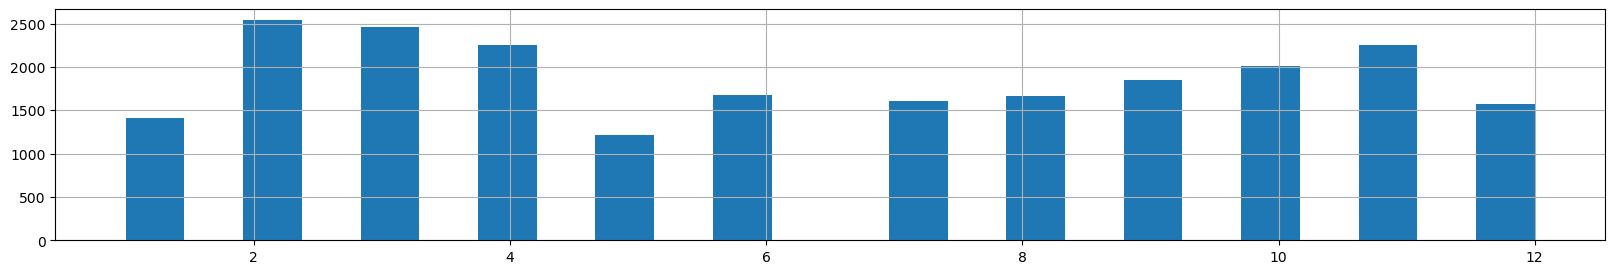

In [416]:
data_cleaned['month'].hist(bins=24,figsize=(20, 3));

**year**

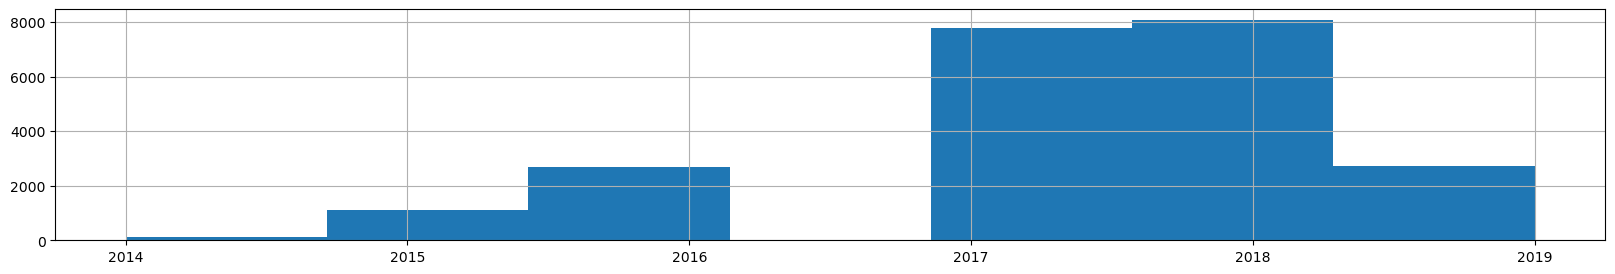

In [417]:
data_cleaned['year'].hist(bins=7,figsize=(20, 3));

**Промежуточный вывод**

Наблюдается характерный всплеск объявлений о продажи недвижимости в 2017-2018 и затем характерный спад в 2019 вероятно время COVID негативно сказалось на рынке недвижимости, в то же время 2017-2018 когда обяъвления были на пике вероятно было связанно с оттоком населения в связи с ростом санкций.

**Скорость продажи недвижимости**

Для анализа скорости продажи квартир создадим вспомогательный датафрейм, в котором будут только те объекты недвижимости, в которых есть информация в столбце 'days_exposition' (предположительно, это объекты, продажа которых завершена).

In [418]:
data_sold = data[~data['days_exposition'].isna()]

Проверим описательную статистику

In [419]:
data_sold['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Промежуточный вывод**
Судя по всему нормальной продолжительностью продажи является срок до шести месяцев; от полугода до полутора лет - долго, но в пределах нормы. Есть случаи, когда объект недвижимости продается и более полутора лет. Такие случаи на рынке недвижимости являются отклонением от общего правила, но также встречаются на практике.


In [420]:
#Посчитаем медиану
data_sold['days_exposition'].median()

95.0

In [421]:
#среднее
data_sold['days_exposition'].mean()

180.88863436982163

<Axes: >

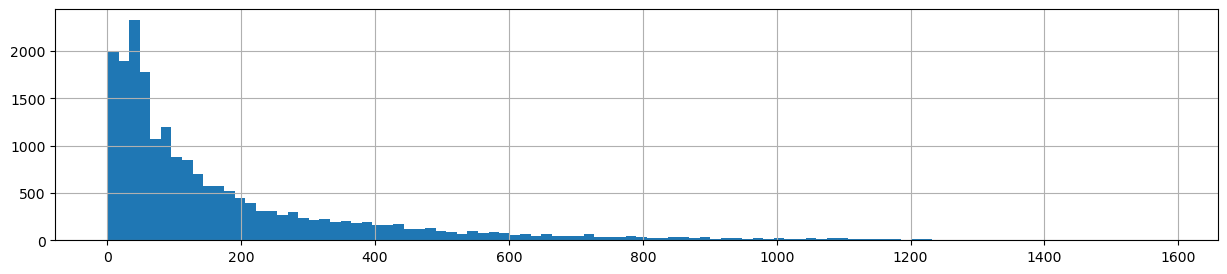

In [422]:
#Посмотрим форму распределения данных в столбце 'days_exposition'
data_sold['days_exposition'].hist(bins=100,figsize=(15, 3))

<Axes: >

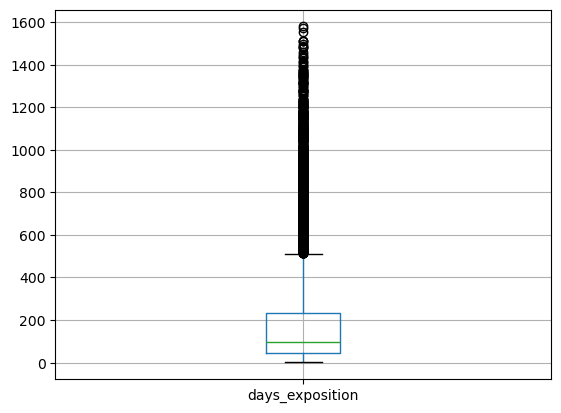

In [423]:
#Посмотрим boxplot для столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].boxplot()

<Axes: >

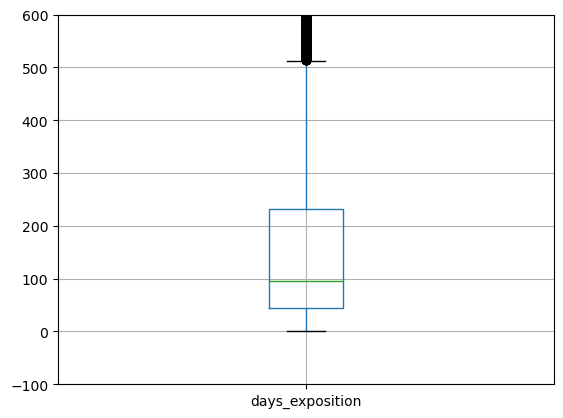

In [424]:
#Посмотрим "ящик с усами" для столбца 'days_exposition' в чуть более увеличенном масштабе:
plt.ylim(-100, 600)
data_sold.loc[:,['days_exposition']].boxplot()


**Промежуточный вывод**

Нижний "ус" отсекает множество на уровне нуля. Это означает, что нижняя граница скорости продаж вписывается в нормальные значения. Что же касается верхней границы - всё, что касается продаж чуть выше 500 дней, является статистическими выбросами. Это "ненормальная" продолжительность продаж, и для выводов о "нормальной" продолжительности продаж такие случаи нам не нужны. От них лучше избавиться.

Сформулируем верхнюю границу выбросов чуть менее радикально. Квартиры, которые продаются на рынке более полутора лет, являются скорее существенным отклонением от нормы по скорости продаж.

In [425]:
#Посмотрим, сколько таких квартир:
print(len(data_sold.loc[data['days_exposition']>365*1.5]),' из ', len(data_sold))

1486  из  20518


**Промежуточный вывод**

Долгопродающиеся квартиры - это около 7% от общей массы объявлений. Довольно существенная доля, однако влияние на качество анализа, которое данные объекты оказывают, скорее отрицательное. Они сильно искажают на статистические показатели скорости продаж. Удалим их.

In [426]:
data_sold = data_sold.loc[data['days_exposition']<365*1.5]

array([[<Axes: title={'center': 'days_exposition'}>]], dtype=object)

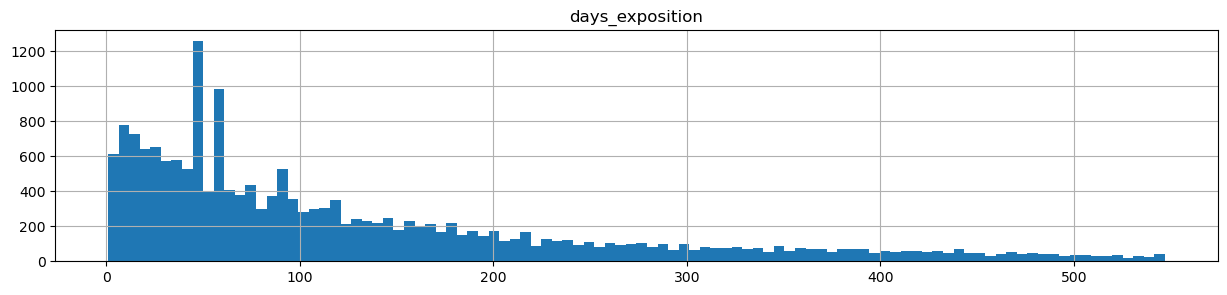

In [427]:
#Посмотрим теперь на гистограмму столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].hist(bins=100,figsize=(15, 3))

**Промежуточный вывод**

На гистограмме есть несколько пиков, которые явно выбиваются из общего тренда. Неплохо было бы посмотреть, какие сроки продажи являются фаворитами по количеству повторений.

In [428]:
data_sold['days_exposition'].value_counts().head(10)

days_exposition
45.0    880
60.0    538
7.0     234
30.0    208
90.0    204
4.0     176
3.0     158
5.0     152
14.0    148
9.0     143
Name: count, dtype: int64

**Промежуточный вывод**

Наиболее частая продолжительность продаж носит слишком системный характер: неделя, месяц, полтора/два/три месяца. Судя по всему, это не продолжительность продажи, а некоторые сроки, в которые объявление должно было быть снято или продлено. В этот же ряд попадает, скорее всего, продолжительность продаж в 14 дней (две недели). Если это действительно так, то строки с данной продолжительностью продаж искажают информацию о реальной продолжительности размещения объявления до момента продажи. Почистим наш датасет от таких строк.

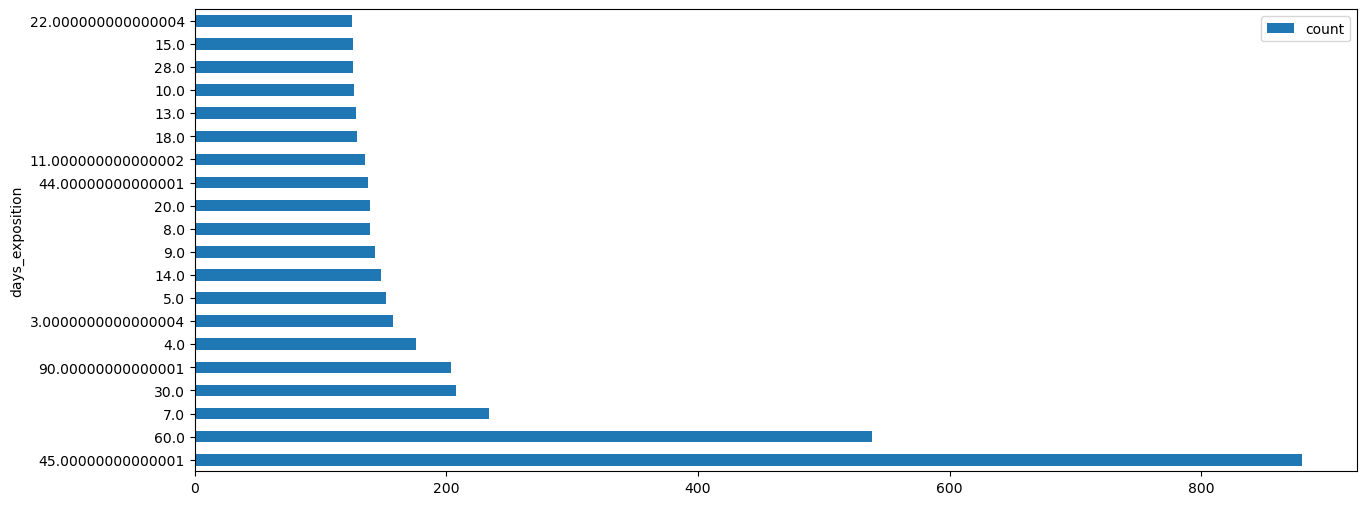

In [429]:
# check
# Моды на реальных данных
     
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

In [430]:
data_sold = data_sold.query('days_exposition not in [7,14,30,45,60,90]')

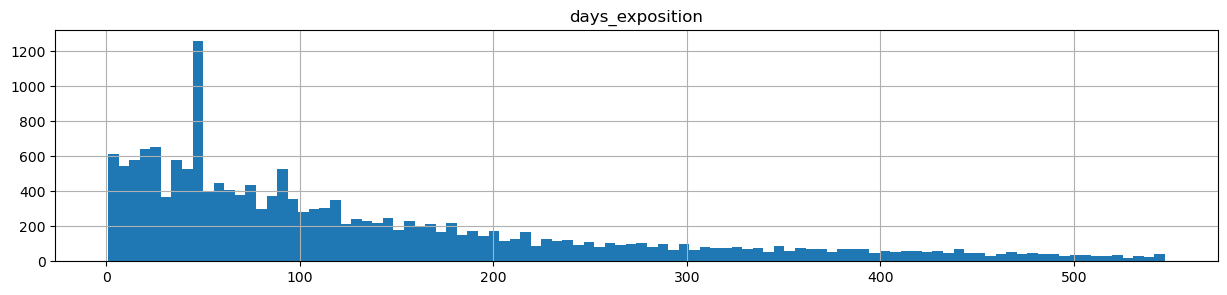

In [431]:
#Посмотрим теперь на гистограмму столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].hist(bins=100,figsize=(15, 3));

**Промежуточный вывод**

Мы очистили наши данные от случайны и систематических ошибок и статистических выбросов и аномалий. Разобъем наш датасет на три равные части по вариативности сроков продаж:

In [432]:
data_sold['days_exposition_type'] = pd.qcut(data_sold['days_exposition'], q=3, labels=['быстро','нормально','медленно'], precision=0, duplicates='drop');


In [433]:
data_sold.pivot_table(index='days_exposition_type', values='days_exposition', aggfunc='max')

/tmp/ipykernel_237246/2478555781.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_sold.pivot_table(index='days_exposition_type', values='days_exposition', aggfunc='max')


,days_exposition
days_exposition_type,
быстро,53.0
нормально,153.0
медленно,547.0


**Вывод:** 

Рынок недвижимости - весьма консервативный. Продажа квартиры в течении двух месяцев считается быстрой; нормальной продолжительностью продажи является срок от двух до шести месяцев; от полугода до полутора лет - долго, но в пределах нормы. Однако не не редки случаи, когда объект недвижимости продается и более полутора лет. Такие случаи на рынке недвижимости являются отклонением от общего правила, но также встречаются на практике.

### Факторы больше всего повлиявшие на общую (полную) стоимость объекта?

Для анализа влияния факторов на цену объекта недвижимости, построим матрицу диаграмм рассеяния для каждого из факторов, чтобы визуально оценить наличие связи между ценой и каждым из факторов (первый столбец матрицы).

In [434]:
#Запишем перечень факторов в переменную `list`.
#Первой укажем цену, тогда первый столбец матрицы покажет нам цависимость цены от каждого из факторов.
list=(['last_price',# цена объекта
       'total_area',# общая площадь
       'living_area',# жилая площадь
       'kitchen_area',# площадь кухни
       'rooms',# количество комнат
       #'floor_type',# тип этажа квартиры
       #'weekday',# день публикации объявления
       #'month',# месяц публикации объявления
       #'year'# месяц публикации объявления
      ])

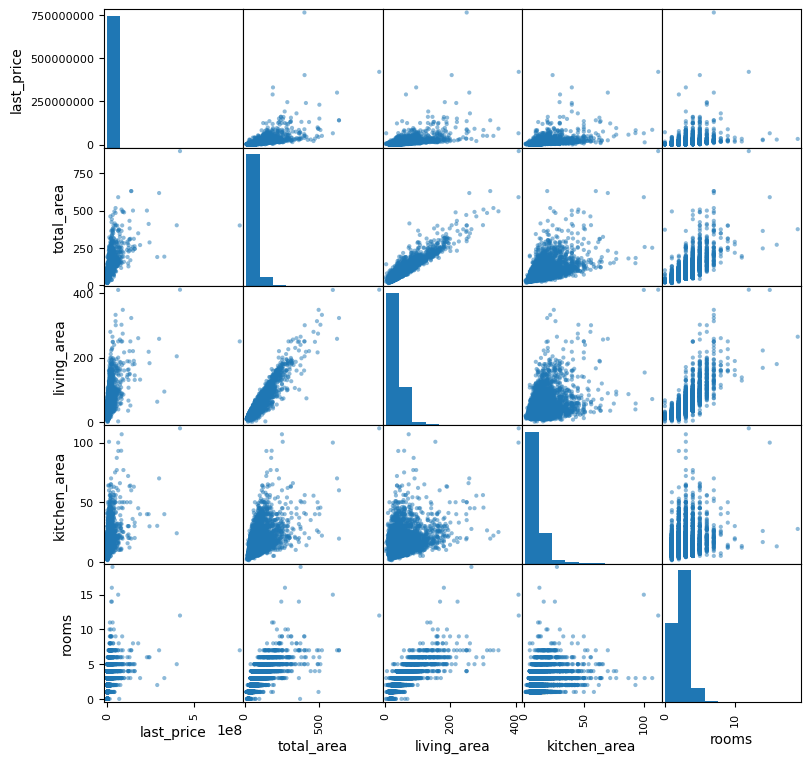

In [435]:
pd.plotting.scatter_matrix(data.loc[:,list], figsize=(9, 9));

Построим на матрицу коэффициентов корреляции, для каждого из параметров:

In [436]:
data.loc[:,list].corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.653675,0.566492,0.519869,0.363343
total_area,0.653675,1.000000,0.939537,0.609121,0.758344
living_area,0.566492,0.939537,1.000000,0.428674,0.845977
kitchen_area,0.519869,0.609121,0.428674,1.000000,0.269945
rooms,0.363343,0.758344,0.845977,0.269945,1.000000


**Вывод:** 

Как видно из приведенных выше данных, первые три фактора (общая площадь, жилая площадь, площадь кухни) оказывают значительное влияние на цену. Общая и жилая площадь, помимо этого, тесно связаны между собой (что вполне логично).

Количество комнат также оказывает влияние на цену, хотя заметно менее существенное.

Скорее, результаты анализа следует интерпретировать следующим образом:

На цену объекта недвижимости оказывает существенное влияние его общая площадь. Влияние, которое оказывают прочие характеристики объекта недвижимости (жилая площадь, площадь кухни, количество комнат) является следствием того, что между данными факторами и общей площадью существует прямая корреляция, а поэтому они показывают также корреляцию и с ценой.

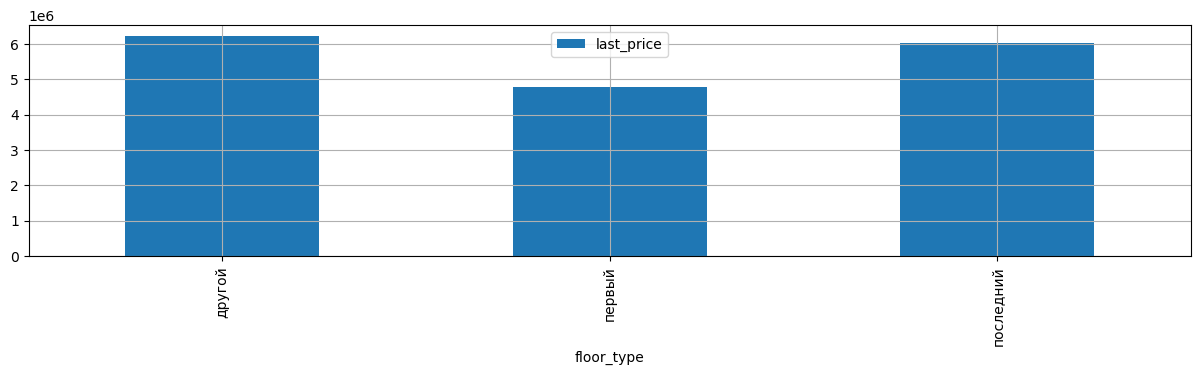

In [437]:
# Изучим, зависит ли цена от этажа
floor_analysis = (data_cleaned.pivot_table(index='floor_type', values='last_price', aggfunc='mean'))
floor_analysis['floor_type'] = floor_analysis.index.astype('string')
floor_analysis.plot( x='floor_type', y='last_price', kind='bar', grid=True, figsize=(15,3));

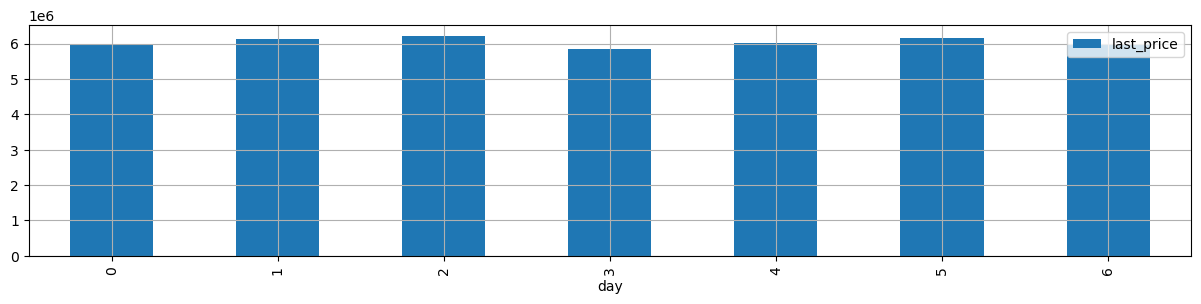

In [438]:
# Изучим, зависит ли цена от дня размещения объявления
day_analysis = (data_cleaned.pivot_table(index='day', values='last_price', aggfunc='mean'))
day_analysis['day'] = day_analysis.index.astype('string')
day_analysis.plot( x='day', y='last_price', kind='bar', grid=True, figsize=(15,3));

**Промежуточный вывод**

В зависимости от дня публикации объявления цена варьируется незначительно. То есть можно предположить что день не влияет на стоимость.


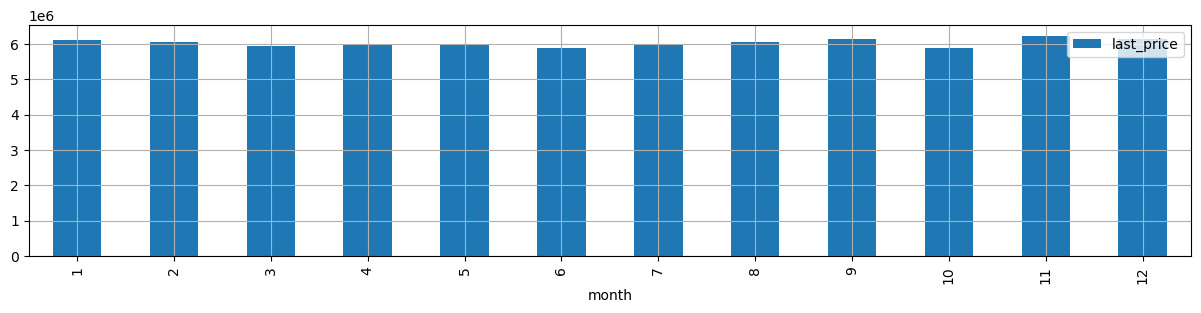

In [439]:
# Изучим, зависит ли цена от месяца размещения объявления
month_analysis = (data_cleaned.pivot_table(index='month', values='last_price', aggfunc='mean'))
month_analysis['month'] = month_analysis.index.astype('string')
month_analysis.plot( x='month', y='last_price', kind='bar', grid=True, figsize=(15,3));

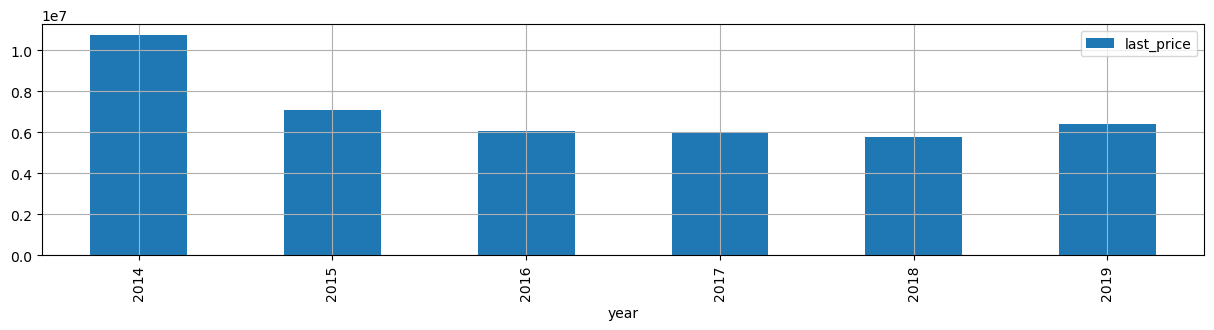

In [440]:
# Изучим, зависит ли цена от года размещения объявления
year_analysis = (data_cleaned.pivot_table(index='year', values='last_price', aggfunc='mean'))
year_analysis['year'] = year_analysis.index.astype('string')
year_analysis.plot( x='year', y='last_price', kind='bar', grid=True, figsize=(15,3));

### Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [441]:
#Сначала отберем 10 населенных пунктов с наибольшим числом объявлений, и запишем список в переменную top_10:
top_10 = data_cleaned['locality_name'].value_counts().index[0:10]
top_10

Index(['санкт-петербург', 'поселок мурино', 'поселок шушары', 'всеволожск',
       'пушкин', 'колпино', 'поселок парголово', 'гатчина', 'деревня кудрово',
       'выборг'],
      dtype='object', name='locality_name')

In [442]:
#Посмотрим среднюю цену в каждом из населенных пунктов списка из Топ-10:
(data_cleaned
     .query('locality_name in @top_10')
     .pivot_table(index='locality_name', values='sqm_cost', aggfunc='mean')
     .sort_values(by='sqm_cost',ascending=False))

,sqm_cost
locality_name,
санкт-петербург,144.483309
пушкин,134.879758
поселок парголово,88.066080
деревня кудрово,86.340246
поселок шушары,83.970165
колпино,80.407822
всеволожск,76.692792
поселок мурино,74.975401
гатчина,70.588889


Определим самую высокую и самую низкую цену квадратного метра, усредненную по каждому населенному пункту:

In [443]:
min_price = data_cleaned.groupby('locality_name')['sqm_cost'].mean().min()
max_price = data_cleaned.groupby('locality_name')['sqm_cost'].mean().max()

Посмотрим, в каком населенном пункте самые низкие цены на недвижимость:

In [444]:
data_cleaned.pivot_table(index='locality_name', values='sqm_cost', aggfunc='mean').query('sqm_cost == @min_price')

,sqm_cost
locality_name,
деревня пижма,5.05618


Посмотрим, в каком населенном пункте самые высокие цены на недвижимость:

In [445]:
data_cleaned.pivot_table(index='locality_name', values='sqm_cost', aggfunc='mean').query('sqm_cost == @max_price')

,sqm_cost
locality_name,
деревня бор,270.602667


**Вывод:** 
    
Неожиданным лидером по максимальной цене квадратного метра оказался поселок репино: зелень, горы - видимо, экология имеет значение</div>

### Недвижимость в Питере

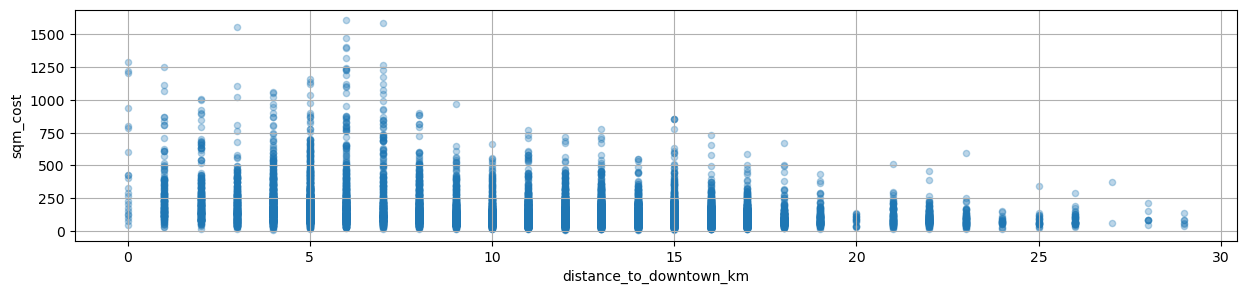

In [446]:
#Построим сначала диаграмму рассеяния для цены квадратного метра в Петербурге в зависимости от расстояния от центра города:
(data_cleaned[data_cleaned['locality_name'] == 'санкт-петербург']
       .plot(
           x='distance_to_downtown_km', 
           y='sqm_cost', 
           kind='scatter', 
           grid=True, 
           alpha=0.3,
           figsize=(15,3)));

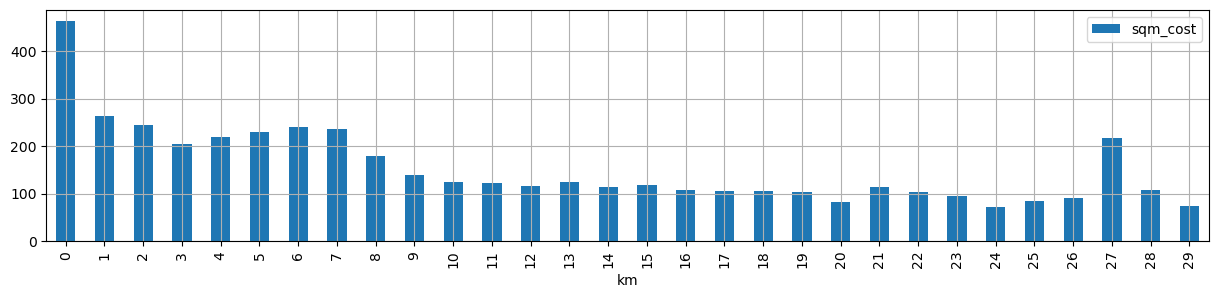

In [447]:
#А теперь столбчатую диаграмму со значением средней цены для каждого из километра:
spb = (data_cleaned[data_cleaned['locality_name'] == 'санкт-петербург']
       .pivot_table(index='distance_to_downtown_km', values='sqm_cost', aggfunc='mean'))
spb['km'] = spb.index.astype('int')
spb.plot( x='km', y='sqm_cost', kind='bar', grid=True, figsize=(15,3));

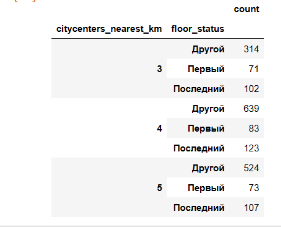

In [448]:

 (data_cleaned[(data_cleaned['locality_name'] == 'санкт-петербург') & 
               (data_cleaned['distance_to_downtown_km'] > 2) &
               (data_cleaned['distance_to_downtown_km'] < 6)]
       .pivot_table(
           index=["distance_to_downtown_km","floor_type"], 
           values=["count"],
           aggfunc='count'))


count
distance_to_downtown_km floor_type       
3.0                     другой        264
                        первый         52
                        последний      20
4.0                     другой        542
                        первый         74
                        последний      41
5.0                     другой        735
                        первый         77
                        последний      45

In [449]:
data_cleaned.head()

,index,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,floor_type,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,distance_to_nearest_airport,distance_to_downtown,distance_to_downtown_km,distance_to_nearest_airport_km,distance_to_nearest_pond_km,distance_to_nearest_park_km,num_of_parks_around_3000m,distance_to_nearest_park,num_of_ponds_around_3000m,distance_to_nearest_pond,days_exposition,sqm_cost,day,month,year,count,price_type
0,0,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,другой,True,False,False,25.0,0,санкт-петербург,18863.0,16028.0,16.0,19.0,1.0,0.0,1,482.0,2,755.0,NaN,120.370370,3,3,2019,1,10
1,1,3350000.0,40.4,2018-12-04,1,2.64,11,18.6,1,первый,True,False,False,11.0,2,поселок шушары,12817.0,18603.0,19.0,13.0,NaN,NaN,0,NaN,0,NaN,81.0,82.920792,1,12,2018,1,3
2,2,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,другой,True,False,False,8.3,0,санкт-петербург,21741.0,13933.0,14.0,22.0,1.0,0.0,1,90.0,2,574.0,558.0,92.785714,3,8,2015,1,6
3,4,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,другой,True,False,False,41.0,0,санкт-петербург,31856.0,8098.0,8.0,32.0,0.0,0.0,2,112.0,1,48.0,121.0,62.893082,4,6,2018,1,10
4,5,2890000.0,30.4,2018-09-10,1,2.64,12,14.4,5,другой,True,False,False,9.1,0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,55.0,28.900000,1,9,2018,1,9


In [450]:
print(spb['km'].corr(spb['sqm_cost']))

-0.7274985540483363


**Промежуточный вывод**

Зависимость цены квадратного метра от расстояния от центра города прослеживается на графике довольно явно, и коэфициент Пирсона это подтверждает.

Чтобы показать закономерность более явно, обобщим информацию о средней цене квадратного метро для более широких групп:
- от 0 до 10 км;
- от 10 до 20 км;
- от 20 до 30 км.

In [451]:
#Создаем пустой список:
km_group = []

#Наполняем список категориальными значениями будущего столбца:
for index in range(len(data_cleaned)):
    if data_cleaned['distance_to_downtown_km'][index] <= 10:
        km_group.append('от 0 до 10 км')
    elif data_cleaned['distance_to_downtown_km'][index] <= 20:
        km_group.append('от 10 до 20 км')
    else:
        km_group.append('от 20 до 30 км')

#Добавляем столбец в датафрейм:
data_cleaned.insert(18,'distance_to_downtown_km_group', km_group, False)
data_cleaned[data_cleaned['locality_name'] == 'санкт-петербург'].groupby('distance_to_downtown_km_group')['sqm_cost'].mean()

distance_to_downtown_km_group
от 0 до 10 км     201.232372
от 10 до 20 км    115.187109
от 20 до 30 км    113.551079
Name: sqm_cost, dtype: float64

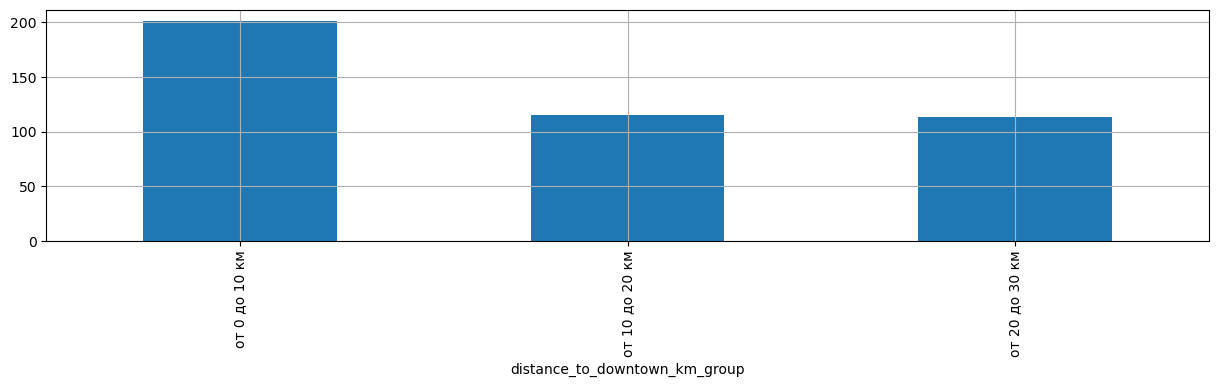

In [452]:
data_cleaned[data_cleaned['locality_name'] == 'санкт-петербург']\
.groupby('distance_to_downtown_km_group')['sqm_cost']\
.mean()\
.plot( x='km', y='sqm_cost', kind='bar', grid=True, figsize=(15,3));

Как видно из графика, всего 10 км от центра значительно снижают стоимость

**Вывод:** 

Анализ влияния удаленности от центра города на стоимость недвижимости на примере Санкт-Петербурга показал, что это влияние довольно существенное (корреляция на уровне 80 %), и по мере удаленности от центра города цена квадратного метра недвижимости падает довольно значительно. Эта тенденция особенно заметна вбизи центра, и сохраняется по мере удаления. Однако темпы падения цены квадратного метра по мере удаления от центра замедляются, что говорит о нелинейном характере этой зависимости.